### 计算机视觉深度学习模型框架：
#### 固定随机数种子和随机算法
#### 创建Dataset类
#### 创建Model类
#### 创建train和validation函数
#### 创建实例，将数据和模型迁移到cuda上，设定epoch进行训练

In [13]:
#导入需要的库
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
import glob
import json  
import time


#固定随机数种子和随机算法
def set_seed(x,torch_use_deterministic_algorithms):
    try:
        import random
        random.seed(x)
    except:
        print('固定随机种子过程中，导入random库失败')
    try:
        import numpy as np
        np.random.seed(x)
    except:
        print('固定随机种子过程中，设置numpy.random的随机种子失败')
    try:
        import os
        os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'  #系统变量需要在torch库开始运行之前设置，不然会报错
        import torch
        torch.random.manual_seed(x)
        torch.cuda.manual_seed_all(x)
        torch.backends.cudnn.deterministic = True
        torch.use_deterministic_algorithms(torch_use_deterministic_algorithms,warn_only=False) 
    except Exception as e:
        print('固定随机种子过程中，固定pytorch的随机种子和随机算法失败，原因为：',e)
      

#创建Dataset
class MyDataset(Dataset):
    '''
    假定图片的数量比较多，label的容量不太大，实例化的时候传入所有image的地址列表以及label.csv的全部内容。
    原始图片的像素不一，为了方便训练，将所有图片的尺寸统一转化成（64，128）
    另外，因为每张图片中的数字长度不一，从1个数字到6个数字，为了简化问题，将所有的label都统一为包含六个数字，其中数字10表示空白。
    '''
    def __init__(self,img_path,label,transforms=None,use_cuda=True):
        self.img_path = img_path
        self.label = label
        self.use_cuda = use_cuda
        if transforms is not None:
            self.transforms = transforms
        else:
            self.transforms = None
            
    def __getitem__(self,index):
        img = Image.open(self.img_path[index]).convert('RGB')
        if self.transforms is not None:
            img = self.transforms(img)
            
        label = self.label[index]
        label = label + (6-len(label))*[10]
        label = torch.from_numpy(np.array(label)).to(torch.long)  #使用CrossEntropyLoss的label需要是long格式的，需要提前进行转换，不然会报错
        
        #如果cuda可用，将数据转移到cuda上
        if self.use_cuda:
            if torch.cuda.is_available():
                img = img.cuda()
                label = label.cuda()  #torch.Tensor.cuda()不是in_place的，但是torch.nn.models.cuda()是in_place的，对于数据的迁移，需要使用data = data.cuda(),而不是data.cuda()
                
        return img,label
    
    def __len__(self):
        return len(self.img_path)
    
    
#创建网络模型
class MyModel(nn.Module):
    '''
    模型以3层卷积接6个全链接层输出结果，不同于MNIST数据集最终只需要输出一个数字，
    这个需要输出包含6个数字的一组数字，而每个位置的数字都有0-9共10种可能性，
    可能性的数量对应全连接层权重的维度，而输出数字的个数对应的是并行的全链接层的个数。
    '''
    def __init__(self):
        super().__init__()
        
        #(50,3,64,128) → (50,16,62,126)
        #(50,16,62,126) → (50,16,62,126)
        #(50,16,62,126) → (50,16,31,63)
        #(50,16,31,63) → (50,32,29,61)
        #(50,32,29,61) → (50,32,29,61)
        #(50,32,29,61) → (50,32,14,30)
        #(50,32,14,30) → (50,64,12,28)
        #(50,64,12,28) → (50,64,12,28)
        #(50,64,12,28) → (50,64,6,14)
        self.cnn = nn.Sequential(nn.Conv2d(3,16,kernel_size=(3,3),stride=(1,1)),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2),
                                 nn.Conv2d(16,32,kernel_size=(3,3),stride=(1,1)),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2),
                                 nn.Conv2d(32,64,kernel_size=(3,3),stride=(1,1)),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2))
        
        #(50,64,6,14) → (50,64*6*14)
        #fc1:(50,64*6*14) → (50,11)输出第一个位置出现0-10中每个数字的可能性，其中10表示空白
        #fc2-fc6:(50,64*6*14) → (50,11)输出第二到第六个位置出现0-10中每个数字的可能性，其中10表示空白
        self.fc1 = nn.Linear(64*6*14,11)
        self.fc2 = nn.Linear(64*6*14,11)
        self.fc3 = nn.Linear(64*6*14,11)
        self.fc4 = nn.Linear(64*6*14,11)
        self.fc5 = nn.Linear(64*6*14,11)
        self.fc6 = nn.Linear(64*6*14,11)
    
    def forward(self,X):
        X = self.cnn(X)
        X = X.view(X.shape[0],-1)
        
        y_position1 = self.fc1(X)
        y_position2 = self.fc2(X)
        y_position3 = self.fc3(X)
        y_position4 = self.fc4(X)
        y_position5 = self.fc5(X)
        y_position6 = self.fc6(X)
                
        return y_position1,y_position2,y_position3,y_position4,y_position5,y_position6
    
    
#创建单个epoch训练函数
def my_train(model,train_data_loader,criterion,optimizer,use_cuda=True):
    
    #开始计时
    start_time = time.time()
    
    #将模型设置为训练模式
    model.train() 
 
    #如果cuda可用，将网络模型和损失函数模型移动到cuda上
    if use_cuda:
        if torch.cuda.is_available():
            model.cuda()
            criterion.cuda()
    my_device = next(model.parameters()).device
    print(f'\t训练设备为{my_device}')
    
    for batch_index,train_data in enumerate(train_data_loader):
        feat,label = train_data
        y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6 = model(feat)

        #这里传入的损失函数是CrossEntropyLoss，它的重要参数有两个，一个是input_data，一个是label
        #其中input的形状一般要求是(N,C)，其中N是batch_size，C是待分类的类别的数量
        #label的形状有两种可以接受的格式，一种形状是(N)，其中每一个元素需要是长整型的，且属于[0,C)的取值范围内，简单来说就是每个数需要是实际值的索引值
        #label的另一种可以接受的形状是与input保持一致，即(N,C)，但是这种情况下每一个元素的值需要在[0,1)之间，即经过softmax之后的值。
        #这里对于label的形状，我们采用第一种格式进行输入，即label的形状为(N)
        #另外，nn.CrossEntropy.Loss有一个默认参数，reduction=mean，这个参数的意思是如何处理每单个数据的各类别计算出来的损失结果。
        #其中，mean表示将对这多个类别的损失结果求和之后取平均值返回，另外还有sum等选项可选
        loss = criterion(y_pred1,label[:,0]) +\
               criterion(y_pred2,label[:,1]) +\
               criterion(y_pred2,label[:,2]) +\
               criterion(y_pred2,label[:,3]) +\
               criterion(y_pred2,label[:,4]) +\
               criterion(y_pred2,label[:,5])
        loss/=6
        
        #计算预测的准确率（六个位置的数值都能对上）
        y1_val = y_pred1.argmax(dim=1,keepdims=True)
        y2_val = y_pred2.argmax(dim=1,keepdims=True)
        y3_val = y_pred3.argmax(dim=1,keepdims=True)
        y4_val = y_pred4.argmax(dim=1,keepdims=True)
        y5_val = y_pred5.argmax(dim=1,keepdims=True)
        y6_val = y_pred6.argmax(dim=1,keepdims=True)
        y_val = torch.cat((y1_val,y2_val,y3_val,y4_val,y5_val,y6_val),dim=1)  #传入torch.cat()的tensor需要以tuple的形式整合在一起
        num_of_right_pred = torch.div((y_val==label).sum(dim=1), label.shape[1], rounding_mode='trunc').sum()
        prediction = num_of_right_pred/label.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 9 == 0:
            print(f'\t第{batch_index}/{len(train_data_loader)}个batch，训练的Loss为{loss},预测准确率为{prediction.round(decimals=2)}')
            
    #结束计时
    end_time = time.time()
    epoch_time = end_time-start_time
    print(f'\tepoch训练时间为{epoch_time}秒\n')
        
    return loss.item(),prediction.round(decimals=2).item(),epoch_time
        
        
#创建验证函数     
def my_validation(model,valid_data_loader,valid_dataset,criterion,use_cuda=True):
    start_time = time.time()
    #将模型设置为验证模型
    model.eval() 
    #如果cuda可用，将网络模型和损失函数模型移动到cuda上
    if use_cuda:
        if torch.cuda.is_available():
            model.cuda()
            criterion.cuda()
    my_device = next(model.parameters()).device
    print(f'\t验证设备为{my_device}')

    total_loss = 0
    num_of_right_pred = 0
    
    with torch.no_grad():
        for batch_index,valid_data in enumerate(valid_data_loader):
            feat,label = valid_data
            y_pred1,y_pred2,y_pred3,y_pred4,y_pred5,y_pred6 = model(feat)
            
            #计算验证集单个batch的平均损失
            loss = criterion(y_pred1,label[:,0]) +\
                   criterion(y_pred2,label[:,1]) +\
                   criterion(y_pred2,label[:,2]) +\
                   criterion(y_pred2,label[:,3]) +\
                   criterion(y_pred2,label[:,4]) +\
                   criterion(y_pred2,label[:,5])
            loss/=6
            total_loss += loss
            
            #计算验证集单个batch中预测正确的个数
            y1_val = y_pred1.argmax(dim=1,keepdims=True)
            y2_val = y_pred2.argmax(dim=1,keepdims=True)
            y3_val = y_pred3.argmax(dim=1,keepdims=True)
            y4_val = y_pred4.argmax(dim=1,keepdims=True)
            y5_val = y_pred5.argmax(dim=1,keepdims=True)
            y6_val = y_pred6.argmax(dim=1,keepdims=True)
            y_val = torch.cat((y1_val,y2_val,y3_val,y4_val,y5_val,y6_val),dim=1)
            num_of_right_pred += torch.div((y_val==label).sum(dim=1), label.shape[1], rounding_mode='trunc').sum()

        total_loss/=(batch_index+1)
        prediction = num_of_right_pred/len(valid_dataset)
    
    end_time = time.time()
    valid_time = end_time-start_time
    print(f'\t验证数据集全部数据用时{valid_time},验证数据集平均损失为{total_loss}，预测准确率为{prediction}，\n')
    
    return total_loss.item(),prediction.round(decimals=2).item()
    

In [3]:
def main(epoch=1,random_seed = 1,use_cuda =True,draw_plot=False,torch_use_deterministic_algorithms=False,learing_rate=0.0001):
    
    start_time = time.time()
    #创建随机种子
    if random_seed is not None:
        set_seed(random_seed,torch_use_deterministic_algorithms)
        if torch_use_deterministic_algorithms:
            print('随机种子设定成功，模式已经修改为固定初始数；torch使用deterministic算法')
        else:
            print('随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法')
    else:
        random_seed = None

    #获取train和valid数据来源
    train_img_path = glob.glob('mchar_train/*.png')
    train_json = json.load(open('mchar_train.json'))
    train_label = [train_json[x]['label'] for x in train_json]

    valid_img_path = glob.glob('mchar_val/*.png')
    valid_json = json.load(open('mchar_val.json'))  #json.load()需要传入一个open()返回的对象
    valid_label = [valid_json[x]['label'] for x in valid_json]

    #确定图像处理步骤
    my_img_transforms = transforms.Compose([transforms.Resize((64,128)),
                                           transforms.ColorJitter(0.3,0.3,0.3),
                                           transforms.RandomRotation(5),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])  #transforms.Compose()接收的是一个list参数，不能是单个的transforms功能直接传入，另外transforms.resize()需要传入tupleer

    #实例化Dataset
    my_train_dataset = MyDataset(train_img_path,train_label,transforms=my_img_transforms,use_cuda=use_cuda)
    my_valid_dataset = MyDataset(valid_img_path,valid_label,transforms=my_img_transforms,use_cuda=use_cuda)

    #实例化网络模型
    cnn_model1 = MyModel() 

    #实例化DataLoader
    my_train_dataloader = DataLoader(my_train_dataset,batch_size=100,shuffle=False)
    my_valid_dataloader = DataLoader(my_valid_dataset,batch_size=100,shuffle=False)
    
    #实例化损失函数
    my_criterion = nn.CrossEntropyLoss()
    
    #实例化优化器
    my_optimizet = torch.optim.Adam(cnn_model1.parameters(),lr=learing_rate) 

    #进行训练，将每个epoch的训练结果和验证结果存入列表
    train_loss_list=[]
    train_prediction_list=[]
    train_epoch_time_list = []
    valid_loss_list=[]
    valid_prediction_list=[]
    
    for epoch_index in range(1,epoch+1):
        print(f'第{epoch_index}个epoch:')
        train_loss,train_prediction,epoch_time = my_train(cnn_model1,my_train_dataloader,my_criterion,my_optimizet,use_cuda=use_cuda)
        valid_loss,valid_prediction = my_validation(cnn_model1,my_valid_dataloader,my_valid_dataset,my_criterion,use_cuda=use_cuda)
        
        train_loss_list.append(train_loss)
        train_prediction_list.append(train_prediction)
        valid_loss_list.append(valid_loss)
        valid_prediction_list.append(valid_prediction)
        train_epoch_time_list.append(epoch_time)
        
    #绘制训练曲线
    if draw_plot:
        fig1 = plt.figure(figsize=(15,10))
        plt.plot([x for x in range(epoch)],train_loss_list,label='train_loss')
        plt.plot([x for x in range(epoch)],train_prediction_list,label='train_prediction')
    #     plt.plot([x for x in range(epoch)],train_epoch_time_list,label='train_epoch_time')
        plt.plot([x for x in range(epoch)],valid_loss_list,label='valid_loss')
        plt.plot([x for x in range(epoch)],valid_prediction_list,label='valid_prediction_list')
        plt.xlabel('epoch')
        plt.ylabel('average loss')
        plt.legend()
        plt.show()
        
    end_time = time.time()
    all_epoch_time = end_time-start_time
    print(f'训练完毕，总用时为{all_epoch_time//60}分，{all_epoch_time%60}秒')
    
    return train_loss_list,train_prediction_list,valid_loss_list,valid_prediction_list,train_epoch_time_list

#### 使用cpu和cuda训练一个epoch的时间对比

In [18]:
if __name__ == '__main__':
    main(1,use_cuda=False,draw_plot=False)

第1个epoch:
	训练设备为cpu
	第0/300个batch，训练的Loss为2.3944780826568604,预测准确率为0.0
	第100/300个batch，训练的Loss为1.3035625219345093,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2891674041748047,预测准确率为0.0
	epoch训练时间为140.22418975830078秒

	验证设备为cpu
	验证数据集全部数据用时31.87879729270935,验证数据集平均损失为1.1365151405334473，预测准确率为0.0，



In [17]:
if __name__ == '__main__':
    main(1,use_cuda=True,draw_plot=False)

第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.389493465423584,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2983564138412476,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2831844091415405,预测准确率为0.0
	epoch训练时间为54.7345929145813秒

	验证设备为cuda:0
	验证数据集全部数据用时19.26254439353943,验证数据集平均损失为1.1305747032165527，预测准确率为0.0，



#### 使用同一个seed和不同seed分别训练3个epoch的计算结果对比（torch不强制使用deterministic算法）

In [35]:
if __name__ == '__main__':
    main(epoch=3,random_seed=1,use_cuda=True,draw_plot=False)

随机种子设定成功，模式已经修改为固定初始数和固定算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.415759563446045,预测准确率为0.0
	第100/300个batch，训练的Loss为1.3115136623382568,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2922782897949219,预测准确率为0.0
	epoch训练时间为61.48640775680542秒

	验证设备为cuda:0
	验证数据集全部数据用时20.04045557975769,验证数据集平均损失为1.142265796661377，预测准确率为0.0，

第2个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.2488852739334106,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2806098461151123,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2767561674118042,预测准确率为0.0
	epoch训练时间为61.60694217681885秒

	验证设备为cuda:0
	验证数据集全部数据用时20.19038462638855,验证数据集平均损失为1.1373951435089111，预测准确率为0.0，

第3个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.2427297830581665,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2742187976837158,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2732958793640137,预测准确率为0.0
	epoch训练时间为60.51160407066345秒

	验证设备为cuda:0
	验证数据集全部数据用时23.370516538619995,验证数据集平均损失为1.128029704093933，预测准确率为0.0，

训练完毕，总用时为4.0分，7.784177303314209秒


In [36]:
if __name__ == '__main__':
    main(epoch=3,random_seed=1,use_cuda=True,draw_plot=False)

随机种子设定成功，模式已经修改为固定初始数和固定算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.415759563446045,预测准确率为0.0
	第100/300个batch，训练的Loss为1.3115136623382568,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2922782897949219,预测准确率为0.0
	epoch训练时间为57.053927183151245秒

	验证设备为cuda:0
	验证数据集全部数据用时19.901807069778442,验证数据集平均损失为1.142265796661377，预测准确率为0.0，

第2个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.2488852739334106,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2806098461151123,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2767561674118042,预测准确率为0.0
	epoch训练时间为61.54811358451843秒

	验证设备为cuda:0
	验证数据集全部数据用时20.096290826797485,验证数据集平均损失为1.1373951435089111，预测准确率为0.0，

第3个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.2427297830581665,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2742187976837158,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2732958793640137,预测准确率为0.0
	epoch训练时间为61.57578635215759秒

	验证设备为cuda:0
	验证数据集全部数据用时22.43491840362549,验证数据集平均损失为1.128029704093933，预测准确率为0.0，

训练完毕，总用时为4.0分，3.223324775695801秒


In [37]:
if __name__ == '__main__':
    main(epoch=3,random_seed=2,use_cuda=True,draw_plot=False)

随机种子设定成功，模式已经修改为固定初始数和固定算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.3010927438735962,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2861580848693848,预测准确率为0.0
	epoch训练时间为57.25458836555481秒

	验证设备为cuda:0
	验证数据集全部数据用时19.761159420013428,验证数据集平均损失为1.1423797607421875，预测准确率为0.0，

第2个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.245815634727478,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2786707878112793,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2798147201538086,预测准确率为0.0
	epoch训练时间为61.15382194519043秒

	验证设备为cuda:0
	验证数据集全部数据用时19.962671518325806,验证数据集平均损失为1.1376549005508423，预测准确率为0.0，

第3个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.2386705875396729,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2741769552230835,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2746646404266357,预测准确率为0.0
	epoch训练时间为62.165205001831055秒

	验证设备为cuda:0
	验证数据集全部数据用时23.025450229644775,验证数据集平均损失为1.1273996829986572，预测准确率为0.0，

训练完毕，总用时为4.0分，4.050931930541992秒


随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.3010927438735962,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2861580848693848,预测准确率为0.0
	epoch训练时间为61.305686712265015秒

	验证设备为cuda:0
	验证数据集全部数据用时19.84496760368347,验证数据集平均损失为1.1423797607421875，预测准确率为0.0，

第2个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.245815634727478,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2786707878112793,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2798147201538086,预测准确率为0.0
	epoch训练时间为59.89600872993469秒

	验证设备为cuda:0
	验证数据集全部数据用时24.840611219406128,验证数据集平均损失为1.1376549005508423，预测准确率为0.0，

第3个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.2386705875396729,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2741769552230835,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2746646404266357,预测准确率为0.0
	epoch训练时间为56.453104972839355秒

	验证设备为cuda:0
	验证数据集全部数据用时20.078653573989868,验证数据集平均损失为1.1273996829986572，预测准确率为0.0，

第4个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.2291926145553589,

	epoch训练时间为60.10059332847595秒

	验证设备为cuda:0
	验证数据集全部数据用时19.599623918533325,验证数据集平均损失为1.0825930833816528，预测准确率为0.0，

第29个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.8990607261657715,预测准确率为0.0
	第100/300个batch，训练的Loss为0.9649574756622314,预测准确率为0.0
	第200/300个batch，训练的Loss为0.9651459455490112,预测准确率为0.0
	epoch训练时间为60.47563171386719秒

	验证设备为cuda:0
	验证数据集全部数据用时22.089977264404297,验证数据集平均损失为1.081614375114441，预测准确率为0.0，

第30个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.9030221700668335,预测准确率为0.0
	第100/300个batch，训练的Loss为0.9547300338745117,预测准确率为0.0
	第200/300个batch，训练的Loss为0.962298572063446,预测准确率为0.0
	epoch训练时间为56.073671102523804秒

	验证设备为cuda:0
	验证数据集全部数据用时19.636515617370605,验证数据集平均损失为1.0837159156799316，预测准确率为0.0，

第31个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.9037411212921143,预测准确率为0.0
	第100/300个batch，训练的Loss为0.9436519145965576,预测准确率为0.0
	第200/300个batch，训练的Loss为0.9536889791488647,预测准确率为0.0
	epoch训练时间为60.74133229255676秒

	验证设备为cuda:0
	验证数据集全部数据用时23.338653087615967,验证数据集平均损失为1.084990382194519，预测准确率为0

	第200/300个batch，训练的Loss为0.878513753414154,预测准确率为0.0
	epoch训练时间为60.4403293132782秒

	验证设备为cuda:0
	验证数据集全部数据用时22.104908227920532,验证数据集平均损失为1.101472020149231，预测准确率为0.0，

第57个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.8163735866546631,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8704158663749695,预测准确率为0.0
	第200/300个batch，训练的Loss为0.8731083869934082,预测准确率为0.0
	epoch训练时间为56.2310106754303秒

	验证设备为cuda:0
	验证数据集全部数据用时19.46999168395996,验证数据集平均损失为1.1005343198776245，预测准确率为0.0，

第58个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7920699119567871,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8714141845703125,预测准确率为0.0
	第200/300个batch，训练的Loss为0.8460621237754822,预测准确率为0.0
	epoch训练时间为59.66805362701416秒

	验证设备为cuda:0
	验证数据集全部数据用时23.60793113708496,验证数据集平均损失为1.1039386987686157，预测准确率为0.0，

第59个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.8100543022155762,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8698588609695435,预测准确率为0.0
	第200/300个batch，训练的Loss为0.8656722903251648,预测准确率为0.0
	epoch训练时间为56.458290100097656秒

	验证设备为cuda:0
	验证数据集全部数据用时19.83

	第100/300个batch，训练的Loss为0.8244669437408447,预测准确率为0.0
	第200/300个batch，训练的Loss为0.8011226654052734,预测准确率为0.0
	epoch训练时间为60.23892879486084秒

	验证设备为cuda:0
	验证数据集全部数据用时24.60227084159851,验证数据集平均损失为1.1370108127593994，预测准确率为0.0，

第85个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7649306058883667,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8413369655609131,预测准确率为0.0
	第200/300个batch，训练的Loss为0.8370311260223389,预测准确率为0.0
	epoch训练时间为56.437750816345215秒

	验证设备为cuda:0
	验证数据集全部数据用时19.62454891204834,验证数据集平均损失为1.1317734718322754，预测准确率为0.0，

第86个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7590624094009399,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8343786597251892,预测准确率为0.0
	第200/300个batch，训练的Loss为0.8107656836509705,预测准确率为0.0
	epoch训练时间为60.35292339324951秒

	验证设备为cuda:0
	验证数据集全部数据用时22.52680206298828,验证数据集平均损失为1.1421639919281006，预测准确率为0.0，

第87个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7624715566635132,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8366310596466064,预测准确率为0.0
	第200/300个batch，训练的Loss为0.8273192644119263,预测准确率为0.0
	epoc

	验证数据集全部数据用时19.765859603881836,验证数据集平均损失为1.171114444732666，预测准确率为0.0，

第112个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.732866644859314,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7918691039085388,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7863461375236511,预测准确率为0.0
	epoch训练时间为60.37691354751587秒

	验证设备为cuda:0
	验证数据集全部数据用时24.27193784713745,验证数据集平均损失为1.1759617328643799，预测准确率为0.0，

第113个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7407945394515991,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8313836455345154,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7961176633834839,预测准确率为0.0
	epoch训练时间为55.932265520095825秒

	验证设备为cuda:0
	验证数据集全部数据用时19.65017342567444,验证数据集平均损失为1.1694867610931396，预测准确率为0.0，

第114个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7510507106781006,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7958669662475586,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7884310483932495,预测准确率为0.0
	epoch训练时间为59.94574594497681秒

	验证设备为cuda:0
	验证数据集全部数据用时23.295291662216187,验证数据集平均损失为1.1799981594085693，预测准确率为0.0，

第115个epoch:
	训练设备为cuda:0
	第0/300个batc

	第100/300个batch，训练的Loss为0.7968375086784363,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7749411463737488,预测准确率为0.0
	epoch训练时间为55.874109745025635秒

	验证设备为cuda:0
	验证数据集全部数据用时19.477303981781006,验证数据集平均损失为1.1950604915618896，预测准确率为0.0，

第140个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7378219962120056,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7641865611076355,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7798515558242798,预测准确率为0.0
	epoch训练时间为59.7358238697052秒

	验证设备为cuda:0
	验证数据集全部数据用时24.20923376083374,验证数据集平均损失为1.1942826509475708，预测准确率为0.0，

第141个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7348339557647705,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7821454405784607,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7590798735618591,预测准确率为0.0
	epoch训练时间为60.30402612686157秒

	验证设备为cuda:0
	验证数据集全部数据用时21.715619564056396,验证数据集平均损失为1.2108123302459717，预测准确率为0.0，

第142个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7210642695426941,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8003766536712646,预测准确率为0.0
	第200/300个batch，训练的Loss为0.759635865688324,预测准确率为0.0
	e

	验证数据集全部数据用时23.500705003738403,验证数据集平均损失为1.2225373983383179，预测准确率为0.0，

第167个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7304660081863403,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7900145053863525,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7549748420715332,预测准确率为0.0
	epoch训练时间为55.59765148162842秒

	验证设备为cuda:0
	验证数据集全部数据用时19.772488355636597,验证数据集平均损失为1.2245532274246216，预测准确率为0.0，

第168个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7265352010726929,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7833014726638794,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7622978091239929,预测准确率为0.0
	epoch训练时间为59.543262004852295秒

	验证设备为cuda:0
	验证数据集全部数据用时22.6279559135437,验证数据集平均损失为1.2302223443984985，预测准确率为0.0，

第169个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7159408330917358,预测准确率为0.0
	第100/300个batch，训练的Loss为0.8117616176605225,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7555813193321228,预测准确率为0.0
	epoch训练时间为55.56381821632385秒

	验证设备为cuda:0
	验证数据集全部数据用时19.609837293624878,验证数据集平均损失为1.2228676080703735，预测准确率为0.0，

第170个epoch:
	训练设备为cuda:0
	第0/300个ba

	第200/300个batch，训练的Loss为0.7391383051872253,预测准确率为0.0
	epoch训练时间为56.23892545700073秒

	验证设备为cuda:0
	验证数据集全部数据用时19.565321445465088,验证数据集平均损失为1.2379885911941528，预测准确率为0.0，

第195个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7108398675918579,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7764742374420166,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7611522674560547,预测准确率为0.0
	epoch训练时间为59.42903661727905秒

	验证设备为cuda:0
	验证数据集全部数据用时23.779228925704956,验证数据集平均损失为1.2513959407806396，预测准确率为0.0，

第196个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7281848192214966,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7816936373710632,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7455973625183105,预测准确率为0.0
	epoch训练时间为55.42377257347107秒

	验证设备为cuda:0
	验证数据集全部数据用时19.42871332168579,验证数据集平均损失为1.2467751502990723，预测准确率为0.0，

第197个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7115017771720886,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7513943910598755,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7499498128890991,预测准确率为0.0
	epoch训练时间为60.06952476501465秒

	验证设备为cuda:0
	验证数据集全部数据

	第100/300个batch，训练的Loss为0.7783969640731812,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7500126361846924,预测准确率为0.0
	epoch训练时间为60.041524171829224秒

	验证设备为cuda:0
	验证数据集全部数据用时23.001939296722412,验证数据集平均损失为1.2640587091445923，预测准确率为0.0，

第223个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7124778628349304,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7686629295349121,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7578933238983154,预测准确率为0.0
	epoch训练时间为56.721829652786255秒

	验证设备为cuda:0
	验证数据集全部数据用时19.641860246658325,验证数据集平均损失为1.2668524980545044，预测准确率为0.0，

第224个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7014471292495728,预测准确率为0.0
	第100/300个batch，训练的Loss为0.775249183177948,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7447679042816162,预测准确率为0.0
	epoch训练时间为60.159583568573秒

	验证设备为cuda:0
	验证数据集全部数据用时23.342909574508667,验证数据集平均损失为1.280142903327942，预测准确率为0.0，

第225个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.697326123714447,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7672211527824402,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7180973887443542,预测准确率为0.0
	ep

	第0/300个batch，训练的Loss为0.7042681574821472,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7560529112815857,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7353433966636658,预测准确率为0.0
	epoch训练时间为60.14948534965515秒

	验证设备为cuda:0
	验证数据集全部数据用时23.405596017837524,验证数据集平均损失为1.298749566078186，预测准确率为0.0，

第251个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7042911052703857,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7576535940170288,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7205979824066162,预测准确率为0.0
	epoch训练时间为55.900166034698486秒

	验证设备为cuda:0
	验证数据集全部数据用时19.674726247787476,验证数据集平均损失为1.2865536212921143，预测准确率为0.0，

第252个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6981716156005859,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7390478849411011,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7429413199424744,预测准确率为0.0
	epoch训练时间为60.11206531524658秒

	验证设备为cuda:0
	验证数据集全部数据用时23.66140913963318,验证数据集平均损失为1.29217529296875，预测准确率为0.0，

第253个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6966990828514099,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7634791731834412,预测准确率为0.0
	第200

	验证数据集全部数据用时23.08870840072632,验证数据集平均损失为1.3069839477539062，预测准确率为0.0，

第278个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6781046390533447,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7530917525291443,预测准确率为0.0
	第200/300个batch，训练的Loss为0.738107442855835,预测准确率为0.0
	epoch训练时间为55.84182024002075秒

	验证设备为cuda:0
	验证数据集全部数据用时19.568867921829224,验证数据集平均损失为1.307179570198059，预测准确率为0.0，

第279个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6949518918991089,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7753405570983887,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7237507104873657,预测准确率为0.0
	epoch训练时间为60.251161336898804秒

	验证设备为cuda:0
	验证数据集全部数据用时23.636895656585693,验证数据集平均损失为1.3024308681488037，预测准确率为0.0，

第280个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6841264963150024,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7634423971176147,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7230995893478394,预测准确率为0.0
	epoch训练时间为56.38674211502075秒

	验证设备为cuda:0
	验证数据集全部数据用时19.70947003364563,验证数据集平均损失为1.3126577138900757，预测准确率为0.0，

第281个epoch:
	训练设备为cuda:0
	第0/300个batc

	第200/300个batch，训练的Loss为0.6954724788665771,预测准确率为0.0
	epoch训练时间为54.49223065376282秒

	验证设备为cuda:0
	验证数据集全部数据用时19.092230081558228,验证数据集平均损失为1.3166446685791016，预测准确率为0.0，

第306个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6813506484031677,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7607907056808472,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7189046740531921,预测准确率为0.0
	epoch训练时间为58.58366632461548秒

	验证设备为cuda:0
	验证数据集全部数据用时21.76987314224243,验证数据集平均损失为1.3342301845550537，预测准确率为0.0，

第307个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6622616052627563,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7460299730300903,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7189528346061707,预测准确率为0.0
	epoch训练时间为54.532522439956665秒

	验证设备为cuda:0
	验证数据集全部数据用时19.288484573364258,验证数据集平均损失为1.329135537147522，预测准确率为0.0，

第308个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6716594099998474,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7314045429229736,预测准确率为0.0
	第200/300个batch，训练的Loss为0.710050106048584,预测准确率为0.0
	epoch训练时间为58.63370418548584秒

	验证设备为cuda:0
	验证数据集全部数据用

	第0/300个batch，训练的Loss为0.6805068254470825,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7305454611778259,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7050622701644897,预测准确率为0.0
	epoch训练时间为54.82345008850098秒

	验证设备为cuda:0
	验证数据集全部数据用时19.026129484176636,验证数据集平均损失为1.3419301509857178，预测准确率为0.0，

第334个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.70294189453125,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7229716181755066,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7017512321472168,预测准确率为0.0
	epoch训练时间为58.070396184921265秒

	验证设备为cuda:0
	验证数据集全部数据用时22.561748266220093,验证数据集平均损失为1.3420443534851074，预测准确率为0.0，

第335个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6993389129638672,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7579593658447266,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7319263815879822,预测准确率为0.0
	epoch训练时间为54.53901481628418秒

	验证设备为cuda:0
	验证数据集全部数据用时19.14985966682434,验证数据集平均损失为1.3413162231445312，预测准确率为0.0，

第336个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6810160875320435,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7678918242454529,预测准确率为0.0
	第20

	验证数据集全部数据用时23.281811714172363,验证数据集平均损失为1.353250503540039，预测准确率为0.0，

第361个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6817541122436523,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7467215061187744,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7064715623855591,预测准确率为0.0
	epoch训练时间为59.762033224105835秒

	验证设备为cuda:0
	验证数据集全部数据用时22.26450204849243,验证数据集平均损失为1.3531575202941895，预测准确率为0.0，

第362个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.700191855430603,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7607097625732422,预测准确率为0.0
	第200/300个batch，训练的Loss为0.706926703453064,预测准确率为0.0
	epoch训练时间为55.098193407058716秒

	验证设备为cuda:0
	验证数据集全部数据用时19.14984369277954,验证数据集平均损失为1.3533433675765991，预测准确率为0.0，

第363个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6906458735466003,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7300698161125183,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6897596120834351,预测准确率为0.0
	epoch训练时间为58.52266240119934秒

	验证设备为cuda:0
	验证数据集全部数据用时21.904346466064453,验证数据集平均损失为1.3547245264053345，预测准确率为0.0，

第364个epoch:
	训练设备为cuda:0
	第0/300个batc

	第200/300个batch，训练的Loss为0.7158199548721313,预测准确率为0.0
	epoch训练时间为54.74276089668274秒

	验证设备为cuda:0
	验证数据集全部数据用时19.426112413406372,验证数据集平均损失为1.3697330951690674，预测准确率为0.0，

第389个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6745625734329224,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7292241454124451,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7002091407775879,预测准确率为0.0
	epoch训练时间为59.00250244140625秒

	验证设备为cuda:0
	验证数据集全部数据用时22.779122352600098,验证数据集平均损失为1.3655601739883423，预测准确率为0.0，

第390个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6623134613037109,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7385348081588745,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7071672677993774,预测准确率为0.0
	epoch训练时间为54.800588846206665秒

	验证设备为cuda:0
	验证数据集全部数据用时19.221654176712036,验证数据集平均损失为1.3643712997436523，预测准确率为0.0，

第391个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6680463552474976,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7270392775535583,预测准确率为0.0
	第200/300个batch，训练的Loss为0.715323805809021,预测准确率为0.0
	epoch训练时间为59.055891036987305秒

	验证设备为cuda:0
	验证数据集全部

	第0/300个batch，训练的Loss为0.6721846461296082,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7431336641311646,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7179986238479614,预测准确率为0.0
	epoch训练时间为55.05738830566406秒

	验证设备为cuda:0
	验证数据集全部数据用时19.193703174591064,验证数据集平均损失为1.3793879747390747，预测准确率为0.0，

第417个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.683718204498291,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7605723142623901,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6924645304679871,预测准确率为0.0
	epoch训练时间为58.7009801864624秒

	验证设备为cuda:0
	验证数据集全部数据用时22.167774200439453,验证数据集平均损失为1.3740285634994507，预测准确率为0.0，

第418个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6710309386253357,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7328847646713257,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6876158714294434,预测准确率为0.0
	epoch训练时间为54.82881712913513秒

	验证设备为cuda:0
	验证数据集全部数据用时19.579702854156494,验证数据集平均损失为1.3765771389007568，预测准确率为0.0，

第419个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6511099338531494,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7430209517478943,预测准确率为0.0
	第20

	验证数据集全部数据用时22.057069540023804,验证数据集平均损失为1.3874512910842896，预测准确率为0.0，

第444个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6681360006332397,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7257143259048462,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6797231435775757,预测准确率为0.0
	epoch训练时间为54.94936442375183秒

	验证设备为cuda:0
	验证数据集全部数据用时19.212650537490845,验证数据集平均损失为1.387640357017517，预测准确率为0.0，

第445个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6432849764823914,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7226011753082275,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6932811737060547,预测准确率为0.0
	epoch训练时间为58.83735251426697秒

	验证设备为cuda:0
	验证数据集全部数据用时22.603641510009766,验证数据集平均损失为1.388472557067871，预测准确率为0.0，

第446个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6655869483947754,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7290047407150269,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6984339952468872,预测准确率为0.0
	epoch训练时间为54.993966579437256秒

	验证设备为cuda:0
	验证数据集全部数据用时19.173754930496216,验证数据集平均损失为1.3803318738937378，预测准确率为0.0，

第447个epoch:
	训练设备为cuda:0
	第0/300个ba

	第200/300个batch，训练的Loss为0.710293710231781,预测准确率为0.0
	epoch训练时间为58.64767575263977秒

	验证设备为cuda:0
	验证数据集全部数据用时22.518805265426636,验证数据集平均损失为1.403615951538086，预测准确率为0.0，

第472个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6622037291526794,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7306445837020874,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6821693778038025,预测准确率为0.0
	epoch训练时间为54.86098575592041秒

	验证设备为cuda:0
	验证数据集全部数据用时19.26316261291504,验证数据集平均损失为1.4051787853240967，预测准确率为0.0，

第473个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6643110513687134,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7214586138725281,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7116718292236328,预测准确率为0.0
	epoch训练时间为58.72312307357788秒

	验证设备为cuda:0
	验证数据集全部数据用时21.85157036781311,验证数据集平均损失为1.397495985031128，预测准确率为0.0，

第474个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6607348918914795,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7159590721130371,预测准确率为0.0
	第200/300个batch，训练的Loss为0.693333089351654,预测准确率为0.0
	epoch训练时间为54.69992280006409秒

	验证设备为cuda:0
	验证数据集全部数据用时19.

	第100/300个batch，训练的Loss为0.7290059924125671,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6668610572814941,预测准确率为0.0
	epoch训练时间为58.70854902267456秒

	验证设备为cuda:0
	验证数据集全部数据用时22.022167682647705,验证数据集平均损失为1.4084612131118774，预测准确率为0.0，

第500个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6561578512191772,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7066254019737244,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6870090961456299,预测准确率为0.0
	epoch训练时间为54.5408616065979秒

	验证设备为cuda:0
	验证数据集全部数据用时19.11989688873291,验证数据集平均损失为1.4050472974777222，预测准确率为0.0，



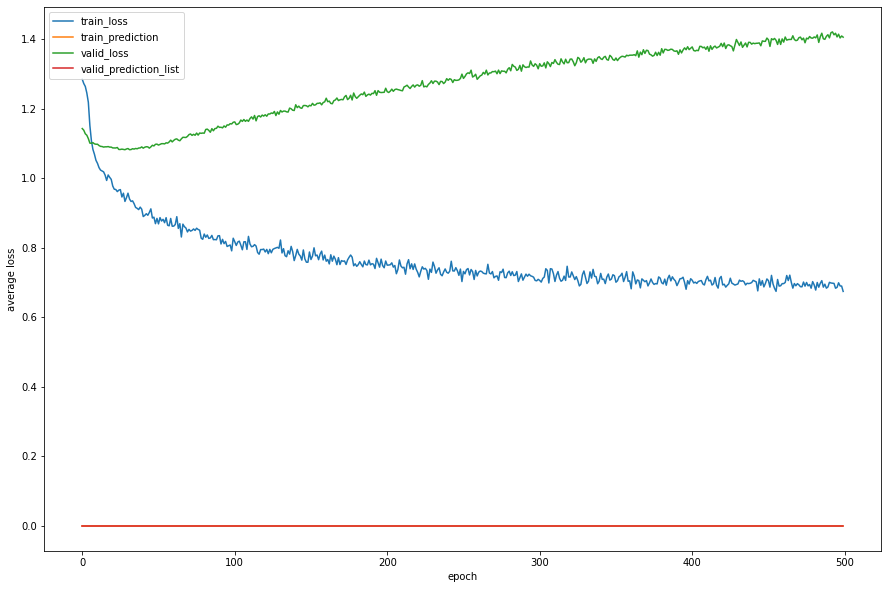

训练完毕，总用时为1046.0分，46.96677231788635秒


In [42]:
if __name__ == '__main__':
    main(epoch=500,random_seed=2,use_cuda=True,draw_plot=True)

#### 通过上面的500个epoch训练发现，模型一直欠拟合，在训练集和验证集的损失一直居高不下。首先尝试修改使用不同的学习率看是否有效

In [5]:
if __name__ == '__main__':
    lr_list = [0.1,0.01,0.001,0.0001,0.00001]
    for lr in lr_list:
        print('lr=',lr)
        main(epoch=1,random_seed=2,use_cuda=True,learing_rate=lr)
        print('\n')

lr= 0.1
随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2854583263397217,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2807555198669434,预测准确率为0.0
	epoch训练时间为267.5927383899689秒

	验证设备为cuda:0
	验证数据集全部数据用时74.96722197532654,验证数据集平均损失为1.1457886695861816，预测准确率为0.0，

训练完毕，总用时为5.0分，43.06629037857056秒


lr= 0.01
随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.284723162651062,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2827339172363281,预测准确率为0.0
	epoch训练时间为87.69033598899841秒

	验证设备为cuda:0
	验证数据集全部数据用时30.13210439682007,验证数据集平均损失为1.1361507177352905，预测准确率为0.0，

训练完毕，总用时为1.0分，58.493180990219116秒


lr= 0.001
随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2773271799087524,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2787301540374756

#### 可以看到，lr在0.01-0.0001之间的时候，表现比较好，现在对这个区间进行进一步的搜索

lr= 0.0001
随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.3010927438735962,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2861580848693848,预测准确率为0.0
	epoch训练时间为88.37307810783386秒

	验证设备为cuda:0
	验证数据集全部数据用时31.19749689102173,验证数据集平均损失为1.1423797607421875，预测准确率为0.0，

训练完毕，总用时为1.0分，59.994349002838135秒


[1.2840354442596436]
lr= 0.0006000000000000001
随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.283602237701416,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2775202989578247,预测准确率为0.0
	epoch训练时间为80.16678094863892秒

	验证设备为cuda:0
	验证数据集全部数据用时27.52868962287903,验证数据集平均损失为1.1255000829696655，预测准确率为0.0，

训练完毕，总用时为1.0分，48.466437339782715秒


[1.2840354442596436, 1.2693443298339844]
lr= 0.0011
随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个b

第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2830859422683716,预测准确率为0.0
	第200/300个batch，训练的Loss为1.284381628036499,预测准确率为0.0
	epoch训练时间为59.03184795379639秒

	验证设备为cuda:0
	验证数据集全部数据用时19.813032627105713,验证数据集平均损失为1.135221004486084，预测准确率为0.0，

训练完毕，总用时为1.0分，19.354819536209106秒


[1.2840354442596436, 1.2693443298339844, 1.254066824913025, 1.2341457605361938, 1.2403483390808105, 1.281091332435608, 1.2830874919891357, 1.2836015224456787, 1.2988137006759644, 1.2861590385437012, 1.2842824459075928, 1.2838506698608398, 1.2835052013397217, 1.2828137874603271, 1.2840290069580078, 1.2841894626617432]
lr= 0.0081
随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2821213006973267,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2833092212677002,预测准确率为0.0
	epoch训练时间为62.23970556259155秒

	验证设备为cuda:0
	验证数据集全部数据用时19.65047025680542,验证数据集平均损失为1.1338746547698975，预测准确率为0.0，

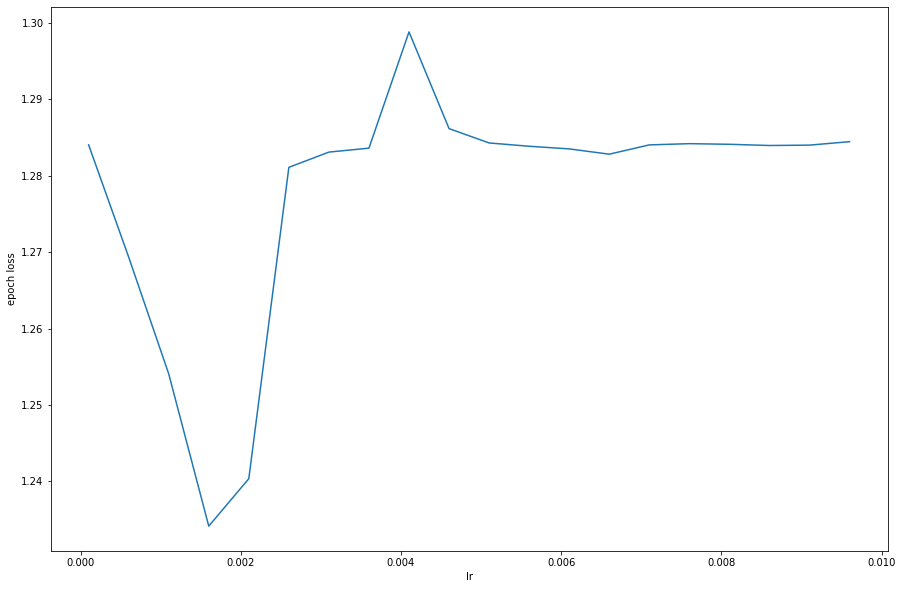

In [11]:
if __name__ == '__main__':
    lr_list = np.arange(0.0001,0.01,0.0005)
    loss_list = []
    for lr in lr_list:
        print('lr=',lr)
        train_loss,_,_,_,_ = main(epoch=1,random_seed=2,use_cuda=True,learing_rate=lr)
        print('\n')
        loss_list.append(train_loss[0])
        print(loss_list)
    
    loss_darray = np.array(loss_list)
    loss_darray = loss_darray*(-1)
    min_lr = np.argmax(loss_darray)*0.0005+0.0001
    min_loss = (-1)*loss_darray[np.argmax(loss_darray)]
    print(f'\n损失最小的学习率为{min_lr},对应的损失为{min_loss}')
    fig1 = plt.figure(figsize=(15,10))
    plt.plot(lr_list,loss_list)
    plt.xlabel('lr')
    plt.ylabel('epoch loss')
    plt.show()

#### 通过上面的测试，学习率设置为0.0016时，训练的效果最好，使用这个学习率，再进行100个epoch的学习，观察效果
相比于lr=0.0001时候稍有提升，但是也能看到，随着epoch增加，loss也几乎不再下降，模型处于欠拟合的状态

随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为2.404719591140747,预测准确率为0.0
	第100/300个batch，训练的Loss为1.2784126996994019,预测准确率为0.0
	第200/300个batch，训练的Loss为1.2779631614685059,预测准确率为0.0
	epoch训练时间为64.73526978492737秒

	验证设备为cuda:0
	验证数据集全部数据用时20.160104990005493,验证数据集平均损失为1.122177004814148，预测准确率为0.0，

第2个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为1.2062921524047852,预测准确率为0.0
	第100/300个batch，训练的Loss为1.1034988164901733,预测准确率为0.0
	第200/300个batch，训练的Loss为1.0585341453552246,预测准确率为0.0
	epoch训练时间为64.05430483818054秒

	验证设备为cuda:0
	验证数据集全部数据用时20.48224902153015,验证数据集平均损失为1.0418727397918701，预测准确率为0.0，

第3个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.9701094627380371,预测准确率为0.0
	第100/300个batch，训练的Loss为1.023932933807373,预测准确率为0.0
	第200/300个batch，训练的Loss为0.9632195234298706,预测准确率为0.0
	epoch训练时间为64.91410160064697秒

	验证设备为cuda:0
	验证数据集全部数据用时25.508809804916382,验证数据集平均损失为1.0342236757278442，预测准确率为0.0，

第4个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.9499618411064148,预测准

	epoch训练时间为65.56577587127686秒

	验证设备为cuda:0
	验证数据集全部数据用时20.110268354415894,验证数据集平均损失为1.0929796695709229，预测准确率为0.0，

第29个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7489814758300781,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7929844856262207,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7545003294944763,预测准确率为0.0
	epoch训练时间为64.9891562461853秒

	验证设备为cuda:0
	验证数据集全部数据用时24.77168035507202,验证数据集平均损失为1.1069316864013672，预测准确率为0.0，

第30个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7220651507377625,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7890298366546631,预测准确率为0.0
	第200/300个batch，训练的Loss为0.76027911901474,预测准确率为0.0
	epoch训练时间为60.72767448425293秒

	验证设备为cuda:0
	验证数据集全部数据用时20.101300477981567,验证数据集平均损失为1.0956343412399292，预测准确率为0.0，

第31个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7334250211715698,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7892772555351257,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7656081914901733,预测准确率为0.0
	epoch训练时间为65.14012289047241秒

	验证设备为cuda:0
	验证数据集全部数据用时20.54168701171875,验证数据集平均损失为1.0843979120254517，预测准确率为0.0，

	第100/300个batch，训练的Loss为0.7444196939468384,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7280693054199219,预测准确率为0.0
	epoch训练时间为60.19956660270691秒

	验证设备为cuda:0
	验证数据集全部数据用时20.065359115600586,验证数据集平均损失为1.1497827768325806，预测准确率为0.0，

第57个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.7068125009536743,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7691596746444702,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7572709321975708,预测准确率为0.0
	epoch训练时间为65.62284684181213秒

	验证设备为cuda:0
	验证数据集全部数据用时20.130188465118408,验证数据集平均损失为1.150136947631836，预测准确率为0.0，

第58个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6797444820404053,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7577032446861267,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7208236455917358,预测准确率为0.0
	epoch训练时间为64.47349238395691秒

	验证设备为cuda:0
	验证数据集全部数据用时23.77142310142517,验证数据集平均损失为1.1256636381149292，预测准确率为0.0，

第59个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6891813278198242,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7602300643920898,预测准确率为0.0
	第200/300个batch，训练的Loss为0.7479950785636902,预测准确率为0.0
	epoc

	第0/300个batch，训练的Loss为0.6848535537719727,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7392370104789734,预测准确率为0.0
	第200/300个batch，训练的Loss为0.712864875793457,预测准确率为0.0
	epoch训练时间为64.66900205612183秒

	验证设备为cuda:0
	验证数据集全部数据用时23.9599506855011,验证数据集平均损失为1.1790534257888794，预测准确率为0.0，

第85个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.680811882019043,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7487119436264038,预测准确率为0.0
	第200/300个batch，训练的Loss为0.729656457901001,预测准确率为0.0
	epoch训练时间为60.98900604248047秒

	验证设备为cuda:0
	验证数据集全部数据用时20.06236982345581,验证数据集平均损失为1.1749340295791626，预测准确率为0.0，

第86个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6925174593925476,预测准确率为0.0
	第100/300个batch，训练的Loss为0.740041971206665,预测准确率为0.0
	第200/300个batch，训练的Loss为0.6919372081756592,预测准确率为0.0
	epoch训练时间为65.18389749526978秒

	验证设备为cuda:0
	验证数据集全部数据用时20.326661348342896,验证数据集平均损失为1.1702938079833984，预测准确率为9.999999747378752e-05，

第87个epoch:
	训练设备为cuda:0
	第0/300个batch，训练的Loss为0.6739052534103394,预测准确率为0.0
	第100/300个batch，训练的Loss为0.7244622707366943,预测准确

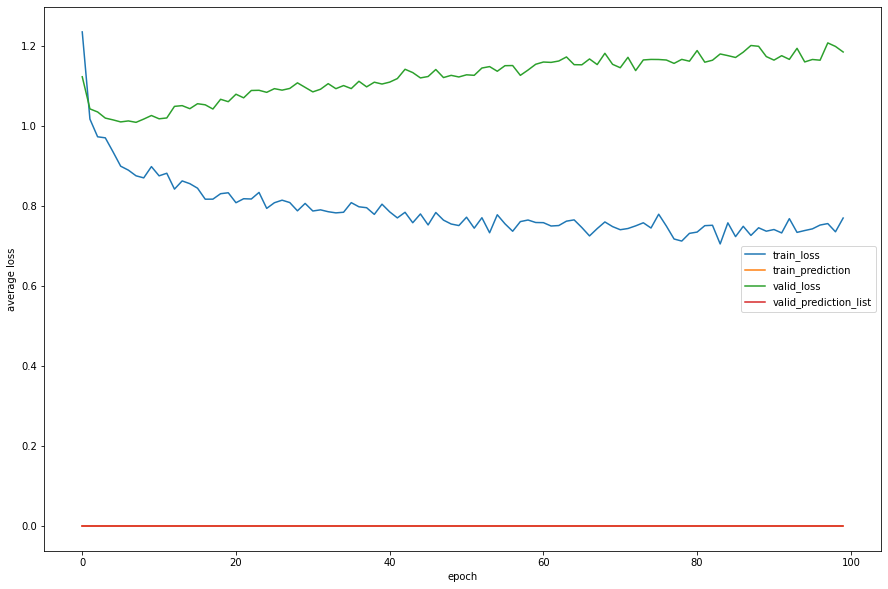

训练完毕，总用时为588.0分，59.76340126991272秒


In [12]:
if __name__ == '__main__':
    main(epoch=100,random_seed=2,use_cuda=True,draw_plot=True,learing_rate=0.0016)

#### 对于欠拟合状态的模型，要么是模型架构本身出了问题，要么是进行训练的数据本身经过转换后输入给模型的时候出了问题，下一步尝试先用比较小的数据集尺寸，让模型能达到过拟合的状态，来判断模型的架构是否有问题
#### 重写main函数，命名为model_test()，只取训练集中的前10个数据进行训练，不进行验证

随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法
第1个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为2.428382396697998,预测准确率为0.0
	第9/10个batch，训练的Loss为1.5533053874969482,预测准确率为0.0
	epoch训练时间为0.19250226020812988秒

第2个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.8094215393066406,预测准确率为0.0
	第9/10个batch，训练的Loss为1.1082485914230347,预测准确率为0.0
	epoch训练时间为0.19052529335021973秒

第3个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5832470655441284,预测准确率为0.0
	第9/10个batch，训练的Loss为0.934554934501648,预测准确率为0.0
	epoch训练时间为0.18314266204833984秒

第4个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为1.4019780158996582,预测准确率为0.0
	第9/10个batch，训练的Loss为0.9339610934257507,预测准确率为0.0
	epoch训练时间为0.19150376319885254秒

第5个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.9967970252037048,预测准确率为0.0
	第9/10个batch，训练的Loss为1.0213947296142578,预测准确率为0.0
	epoch训练时间为0.18852615356445312秒

第6个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.8465344905853271,预测准确率为0.0
	第9/10个batch，训练的Loss为0.79002445936203,预测准确率为0.0
	epoch训练时间为0.20745086669921875秒

第7个epoch:
	训练设备为cud

	第9/10个batch，训练的Loss为0.4348701238632202,预测准确率为0.0
	epoch训练时间为0.1845235824584961秒

第55个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41958925127983093,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4432182013988495,预测准确率为0.0
	epoch训练时间为0.18079161643981934秒

第56个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43068796396255493,预测准确率为0.0
	第9/10个batch，训练的Loss为1.190529704093933,预测准确率为0.0
	epoch训练时间为0.18352580070495605秒

第57个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4413693845272064,预测准确率为0.0
	第9/10个batch，训练的Loss为0.47694215178489685,预测准确率为0.0
	epoch训练时间为0.18552088737487793秒

第58个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4329933524131775,预测准确率为0.0
	第9/10个batch，训练的Loss为0.6587738394737244,预测准确率为0.0
	epoch训练时间为0.17876672744750977秒

第59个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.44866782426834106,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42243850231170654,预测准确率为0.0
	epoch训练时间为0.17853641510009766秒

第60个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43188533186912537,预测准确率为0.0
	第9/10个batch，训练的Loss为0.6620556712150574,预测准确率为0.0
	epo

	epoch训练时间为0.18851256370544434秒

第107个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42295557260513306,预测准确率为0.0
	第9/10个batch，训练的Loss为0.586452066898346,预测准确率为0.0
	epoch训练时间为0.1765429973602295秒

第108个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4365946054458618,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5797901749610901,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第109个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42725670337677,预测准确率为0.0
	第9/10个batch，训练的Loss为0.43524104356765747,预测准确率为0.0
	epoch训练时间为0.18552064895629883秒

第110个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.8194292783737183,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42486903071403503,预测准确率为0.0
	epoch训练时间为0.18053388595581055秒

第111个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4330635070800781,预测准确率为0.0
	第9/10个batch，训练的Loss为0.501933753490448,预测准确率为0.0
	epoch训练时间为0.18551087379455566秒

第112个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.806771457195282,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4427245259284973,预测准确率为0.0
	epoch训练时间为0.18951129913330078秒

第113个epoch:
	训练设备为cuda

	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.8091422915458679,预测准确率为0.0
	第9/10个batch，训练的Loss为0.44755107164382935,预测准确率为0.0
	epoch训练时间为0.18352580070495605秒

第160个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41975289583206177,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4275088310241699,预测准确率为0.0
	epoch训练时间为0.18552064895629883秒

第161个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42511653900146484,预测准确率为0.0
	第9/10个batch，训练的Loss为0.45435500144958496,预测准确率为0.0
	epoch训练时间为0.18252849578857422秒

第162个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173623323440552,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42084836959838867,预测准确率为0.0
	epoch训练时间为0.1845235824584961秒

第163个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.418170303106308,预测准确率为0.0
	第9/10个batch，训练的Loss为0.427456259727478,预测准确率为0.0
	epoch训练时间为0.18552041053771973秒

第164个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4211464524269104,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42398369312286377,预测准确率为0.0
	epoch训练时间为0.18352389335632324秒

第165个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5748749375343

	第9/10个batch，训练的Loss为0.5713393092155457,预测准确率为0.0
	epoch训练时间为0.1795361042022705秒

第213个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4235488772392273,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4190913438796997,预测准确率为0.0
	epoch训练时间为0.17633318901062012秒

第214个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4267493188381195,预测准确率为0.0
	第9/10个batch，训练的Loss为0.459602952003479,预测准确率为0.0
	epoch训练时间为0.18053436279296875秒

第215个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43133029341697693,预测准确率为0.0
	第9/10个batch，训练的Loss为0.43836912512779236,预测准确率为0.0
	epoch训练时间为0.17554593086242676秒

第216个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41890749335289,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41880378127098083,预测准确率为0.0
	epoch训练时间为0.17454886436462402秒

第217个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43069618940353394,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4186062514781952,预测准确率为0.0
	epoch训练时间为0.18252849578857422秒

第218个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4248911738395691,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4206814467906952,预测准确率为0.0
	e

	第9/10个batch，训练的Loss为0.44995516538619995,预测准确率为0.0
	epoch训练时间为0.16657805442810059秒

第266个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41921722888946533,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7989854216575623,预测准确率为0.0
	epoch训练时间为0.16556429862976074秒

第267个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4678928554058075,预测准确率为0.0
	第9/10个batch，训练的Loss为0.467448890209198,预测准确率为0.0
	epoch训练时间为0.17786884307861328秒

第268个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4222143590450287,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42998310923576355,预测准确率为0.0
	epoch训练时间为0.18851256370544434秒

第269个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为1.0269787311553955,预测准确率为0.0
	第9/10个batch，训练的Loss为0.6385862231254578,预测准确率为0.0
	epoch训练时间为0.1605842113494873秒

第270个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.9287596940994263,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4549262225627899,预测准确率为0.0
	epoch训练时间为0.16357874870300293秒

第271个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.473697304725647,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4662521779537201,预测准确率为0.0
	e

	第9/10个batch，训练的Loss为0.4188399016857147,预测准确率为0.0
	epoch训练时间为0.1625819206237793秒

第319个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5639142990112305,预测准确率为0.0
	第9/10个batch，训练的Loss为0.43373924493789673,预测准确率为0.0
	epoch训练时间为0.1575939655303955秒

第320个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4185025095939636,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4231383502483368,预测准确率为0.0
	epoch训练时间为0.17756223678588867秒

第321个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4197711944580078,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4219070076942444,预测准确率为0.0
	epoch训练时间为0.16257929801940918秒

第322个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41899868845939636,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42895346879959106,预测准确率为0.0
	epoch训练时间为0.16058588027954102秒

第323个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7944812178611755,预测准确率为0.0
	第9/10个batch，训练的Loss为0.44483983516693115,预测准确率为0.0
	epoch训练时间为0.1546003818511963秒

第324个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41824445128440857,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42140960693359375,预测准确率为0.0

	第9/10个batch，训练的Loss为0.41777944564819336,预测准确率为0.0
	epoch训练时间为0.1575925350189209秒

第371个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41725486516952515,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4189315736293793,预测准确率为0.0
	epoch训练时间为0.160597562789917秒

第372个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.421830952167511,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5658180713653564,预测准确率为0.0
	epoch训练时间为0.16456246376037598秒

第373个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.427482545375824,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5649763345718384,预测准确率为0.0
	epoch训练时间为0.15460705757141113秒

第374个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179050326347351,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42558348178863525,预测准确率为0.0
	epoch训练时间为0.1654524803161621秒

第375个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41828596591949463,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5647448301315308,预测准确率为0.0
	epoch训练时间为0.15746736526489258秒

第376个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7945824861526489,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5633572340011597,预测准确率为0.0
	epo

	第9/10个batch，训练的Loss为0.4230506122112274,预测准确率为0.0
	epoch训练时间为0.18252873420715332秒

第424个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41763490438461304,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4187318682670593,预测准确率为0.0
	epoch训练时间为0.16752266883850098秒

第425个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4196021556854248,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171682596206665,预测准确率为0.0
	epoch训练时间为0.1715559959411621秒

第426个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.793531596660614,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41797754168510437,预测准确率为0.0
	epoch训练时间为0.17255783081054688秒

第427个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42085641622543335,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41736751794815063,预测准确率为0.0
	epoch训练时间为0.1815347671508789秒

第428个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4812764525413513,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4234866499900818,预测准确率为0.0
	epoch训练时间为0.16756796836853027秒

第429个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4451521039009094,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4195895791053772,预测准确率为0.0
	

	第9/10个batch，训练的Loss为0.43515491485595703,预测准确率为0.0
	epoch训练时间为0.16158223152160645秒

第476个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7994067668914795,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5499290227890015,预测准确率为0.0
	epoch训练时间为0.15559768676757812秒

第477个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175935983657837,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4449330270290375,预测准确率为0.0
	epoch训练时间为0.15692543983459473秒

第478个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5639965534210205,预测准确率为0.0
	第9/10个batch，训练的Loss为0.8047552108764648,预测准确率为0.0
	epoch训练时间为0.15260648727416992秒

第479个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42118939757347107,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4606054425239563,预测准确率为0.0
	epoch训练时间为0.16060781478881836秒

第480个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.6011286973953247,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41757458448410034,预测准确率为0.0
	epoch训练时间为0.15659523010253906秒

第481个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.48666912317276,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7600767016410828,预测准确率为0.0
	

	第9/10个batch，训练的Loss为0.420177161693573,预测准确率为0.0
	epoch训练时间为0.17029500007629395秒

第529个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41748589277267456,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174336791038513,预测准确率为0.0
	epoch训练时间为0.17654705047607422秒

第530个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41717076301574707,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4202573299407959,预测准确率为0.0
	epoch训练时间为0.16272258758544922秒

第531个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5617426633834839,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4354602098464966,预测准确率为0.0
	epoch训练时间为0.152862548828125秒

第532个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5621030926704407,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4201335608959198,预测准确率为0.0
	epoch训练时间为0.162581205368042秒

第533个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.420071542263031,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4231427311897278,预测准确率为0.0
	epoch训练时间为0.1575915813446045秒

第534个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173160493373871,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42061346769332886,预测准确率为0.0
	epoch

	epoch训练时间为0.17754101753234863秒

第581个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4184287488460541,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7933303713798523,预测准确率为0.0
	epoch训练时间为0.16357755661010742秒

第582个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42487940192222595,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5675579309463501,预测准确率为0.0
	epoch训练时间为0.16457462310791016秒

第583个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7927476167678833,预测准确率为0.0
	第9/10个batch，训练的Loss为0.564115047454834,预测准确率为0.0
	epoch训练时间为0.17454862594604492秒

第584个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176118075847626,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4192066192626953,预测准确率为0.0
	epoch训练时间为0.15659570693969727秒

第585个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41809654235839844,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41764384508132935,预测准确率为0.0
	epoch训练时间为0.15360307693481445秒

第586个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41840800642967224,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4523228406906128,预测准确率为0.0
	epoch训练时间为0.15861248970031738秒

第587个epoch:
	训练设

	第9/10个batch，训练的Loss为0.41712602972984314,预测准确率为0.0
	epoch训练时间为0.1566169261932373秒

第635个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4247150123119354,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4230750501155853,预测准确率为0.0
	epoch训练时间为0.1575913429260254秒

第636个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4181901812553406,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42253726720809937,预测准确率为0.0
	epoch训练时间为0.1605854034423828秒

第637个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41880959272384644,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4222868084907532,预测准确率为0.0
	epoch训练时间为0.15894174575805664秒

第638个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4187765121459961,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42037829756736755,预测准确率为0.0
	epoch训练时间为0.15958809852600098秒

第639个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179137349128723,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42012518644332886,预测准确率为0.0
	epoch训练时间为0.15659523010253906秒

第640个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174681305885315,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5656494498252869,预测准确率为0.0


	第9/10个batch，训练的Loss为0.4186943471431732,预测准确率为0.0
	epoch训练时间为0.15659546852111816秒

第687个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41729745268821716,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7975983023643494,预测准确率为0.0
	epoch训练时间为0.15360093116760254秒

第688个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7955352663993835,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42064744234085083,预测准确率为0.0
	epoch训练时间为0.1575937271118164秒

第689个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417606920003891,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41975778341293335,预测准确率为0.0
	epoch训练时间为0.15559720993041992秒

第690个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4195379912853241,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179387092590332,预测准确率为0.0
	epoch训练时间为0.16656970977783203秒

第691个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176754355430603,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4582788646221161,预测准确率为0.0
	epoch训练时间为0.17255425453186035秒

第692个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4186627268791199,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5617569088935852,预测准确率为0.0
	

	第9/10个batch，训练的Loss为0.4183962941169739,预测准确率为0.0
	epoch训练时间为0.1697845458984375秒

第740个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4193660616874695,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42335328459739685,预测准确率为0.0
	epoch训练时间为0.16956186294555664秒

第741个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4184032380580902,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4182201027870178,预测准确率为0.0
	epoch训练时间为0.1735517978668213秒

第742个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5622636675834656,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175446033477783,预测准确率为0.0
	epoch训练时间为0.16957473754882812秒

第743个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41928571462631226,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41727182269096375,预测准确率为0.0
	epoch训练时间为0.1735389232635498秒

第744个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41806623339653015,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4218648076057434,预测准确率为0.0
	epoch训练时间为0.181532621383667秒

第745个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.56257164478302,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177790582180023,预测准确率为0.0
	epoc

	epoch训练时间为0.18552064895629883秒

第792个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174913167953491,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4187111258506775,预测准确率为0.0
	epoch训练时间为0.1735515594482422秒

第793个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171238839626312,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5612515211105347,预测准确率为0.0
	epoch训练时间为0.1715526580810547秒

第794个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.418172687292099,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178481996059418,预测准确率为0.0
	epoch训练时间为0.16956162452697754秒

第795个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41734036803245544,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173731803894043,预测准确率为0.0
	epoch训练时间为0.19750165939331055秒

第796个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4198196530342102,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176371097564697,预测准确率为0.0
	epoch训练时间为0.1705477237701416秒

第797个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4184132516384125,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173579216003418,预测准确率为0.0
	epoch训练时间为0.17187118530273438秒

第798个epoch:
	训练设备为cuda

	epoch训练时间为0.17554640769958496秒

第845个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4219987094402313,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4289272725582123,预测准确率为0.0
	epoch训练时间为0.16956162452697754秒

第846个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4188706874847412,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4672786593437195,预测准确率为0.0
	epoch训练时间为0.17754173278808594秒

第847个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41968637704849243,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4204402565956116,预测准确率为0.0
	epoch训练时间为0.1685647964477539秒

第848个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41974112391471863,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7952556610107422,预测准确率为0.0
	epoch训练时间为0.15958762168884277秒

第849个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41873452067375183,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41750508546829224,预测准确率为0.0
	epoch训练时间为0.16158223152160645秒

第850个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177637994289398,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42144274711608887,预测准确率为0.0
	epoch训练时间为0.17630553245544434秒

第851个epoch:
	训练

	第9/10个batch，训练的Loss为0.4176592230796814,预测准确率为0.0
	epoch训练时间为0.15859007835388184秒

第899个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4209391474723816,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7975027561187744,预测准确率为0.0
	epoch训练时间为0.15559792518615723秒

第900个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4194284677505493,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4185020327568054,预测准确率为0.0
	epoch训练时间为0.16357779502868652秒

第901个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.424266517162323,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42385920882225037,预测准确率为0.0
	epoch训练时间为0.1639537811279297秒

第902个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7925267219543457,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4224414825439453,预测准确率为0.0
	epoch训练时间为0.16692113876342773秒

第903个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4209635853767395,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42631036043167114,预测准确率为0.0
	epoch训练时间为0.1605842113494873秒

第904个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43928998708724976,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42454811930656433,预测准确率为0.0
	

	第9/10个batch，训练的Loss为0.41713201999664307,预测准确率为0.0
	epoch训练时间为0.15958762168884277秒

第952个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42024657130241394,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41736119985580444,预测准确率为0.0
	epoch训练时间为0.17953824996948242秒

第953个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41959020495414734,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4227491617202759,预测准确率为0.0
	epoch训练时间为0.16054081916809082秒

第954个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7948335409164429,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42346692085266113,预测准确率为0.0
	epoch训练时间为0.17156624794006348秒

第955个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41843414306640625,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42461761832237244,预测准确率为0.0
	epoch训练时间为0.16257953643798828秒

第956个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41852444410324097,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4454526901245117,预测准确率为0.0
	epoch训练时间为0.17623472213745117秒

第957个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171430766582489,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170484244823456,预测准确

	epoch训练时间为0.17554640769958496秒

第1004个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5615718364715576,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42124253511428833,预测准确率为0.0
	epoch训练时间为0.1735520362854004秒

第1005个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41740870475769043,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41934287548065186,预测准确率为0.0
	epoch训练时间为0.17754197120666504秒

第1006个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609071254730225,预测准确率为0.0
	第9/10个batch，训练的Loss为0.418213814496994,预测准确率为0.0
	epoch训练时间为0.17557549476623535秒

第1007个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174521565437317,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41895103454589844,预测准确率为0.0
	epoch训练时间为0.16956257820129395秒

第1008个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170725345611572,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4201480746269226,预测准确率为0.0
	epoch训练时间为0.15677356719970703秒

第1009个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5623308420181274,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922913432121277,预测准确率为0.0
	epoch训练时间为0.158280611038208秒

第1010个epoch:


	第9/10个batch，训练的Loss为0.41936489939689636,预测准确率为0.0
	epoch训练时间为0.16756725311279297秒

第1057个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4183560311794281,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41713178157806396,预测准确率为0.0
	epoch训练时间为0.1728043556213379秒

第1058个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609936714172363,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41941890120506287,预测准确率为0.0
	epoch训练时间为0.1655721664428711秒

第1059个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41920191049575806,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170805811882019,预测准确率为0.0
	epoch训练时间为0.15958786010742188秒

第1060个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42022037506103516,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171523451805115,预测准确率为0.0
	epoch训练时间为0.16633367538452148秒

第1061个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417627215385437,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41718506813049316,预测准确率为0.0
	epoch训练时间为0.15559840202331543秒

第1062个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608552694320679,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41786202788352966,预测

	第9/10个batch，训练的Loss为0.46744006872177124,预测准确率为0.0
	epoch训练时间为0.16058635711669922秒

第1109个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4749719798564911,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700291633605957,预测准确率为0.0
	epoch训练时间为0.15659761428833008秒

第1110个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4770301282405853,预测准确率为0.0
	第9/10个batch，训练的Loss为0.45254987478256226,预测准确率为0.0
	epoch训练时间为0.16060638427734375秒

第1111个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4243159890174866,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42305561900138855,预测准确率为0.0
	epoch训练时间为0.15659499168395996秒

第1112个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170718193054199,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4331596791744232,预测准确率为0.0
	epoch训练时间为0.1642627716064453秒

第1113个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4286535680294037,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4361792802810669,预测准确率为0.0
	epoch训练时间为0.15659809112548828秒

第1114个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4331102967262268,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4219236373901367,预测准

	第9/10个batch，训练的Loss为0.793708324432373,预测准确率为0.0
	epoch训练时间为0.15859007835388184秒

第1162个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41899240016937256,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919926047325134,预测准确率为0.0
	epoch训练时间为0.15260624885559082秒

第1163个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417449951171875,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173707365989685,预测准确率为0.0
	epoch训练时间为0.16457486152648926秒

第1164个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41727423667907715,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4187026917934418,预测准确率为0.0
	epoch训练时间为0.15559792518615723秒

第1165个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4181821942329407,预测准确率为0.0
	第9/10个batch，训练的Loss为0.563230037689209,预测准确率为0.0
	epoch训练时间为0.16158270835876465秒

第1166个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4196808934211731,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4182168245315552,预测准确率为0.0
	epoch训练时间为0.15559816360473633秒

第1167个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41757604479789734,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174102246761322,预测准确率为

	第9/10个batch，训练的Loss为0.4172936677932739,预测准确率为0.0
	epoch训练时间为0.16455388069152832秒

第1214个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417301744222641,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41726547479629517,预测准确率为0.0
	epoch训练时间为0.15814900398254395秒

第1215个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41715651750564575,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41805967688560486,预测准确率为0.0
	epoch训练时间为0.15859031677246094秒

第1216个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170123338699341,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41801345348358154,预测准确率为0.0
	epoch训练时间为0.1546006202697754秒

第1217个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41905903816223145,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41729986667633057,预测准确率为0.0
	epoch训练时间为0.16064882278442383秒

第1218个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5611513257026672,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7936033010482788,预测准确率为0.0
	epoch训练时间为0.15360212326049805秒

第1219个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41718146204948425,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609947443008423,预

	第9/10个batch，训练的Loss为0.7934293746948242,预测准确率为0.0
	epoch训练时间为0.15751433372497559秒

第1266个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5651627779006958,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4239957928657532,预测准确率为0.0
	epoch训练时间为0.16359853744506836秒

第1267个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4184081554412842,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41966235637664795,预测准确率为0.0
	epoch训练时间为0.16255807876586914秒

第1268个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41998597979545593,预测准确率为0.0
	第9/10个batch，训练的Loss为0.793531596660614,预测准确率为0.0
	epoch训练时间为0.17953801155090332秒

第1269个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4189711809158325,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178445041179657,预测准确率为0.0
	epoch训练时间为0.16158127784729004秒

第1270个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171780049800873,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170151650905609,预测准确率为0.0
	epoch训练时间为0.16956186294555664秒

第1271个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417757123708725,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41767197847366333,预测准确率

	第9/10个batch，训练的Loss为0.4179874360561371,预测准确率为0.0
	epoch训练时间为0.1765429973602295秒

第1318个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4183187484741211,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7936360239982605,预测准确率为0.0
	epoch训练时间为0.17255425453186035秒

第1319个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170680642127991,预测准确率为0.0
	第9/10个batch，训练的Loss为0.418222039937973,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第1320个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5624379515647888,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175928831100464,预测准确率为0.0
	epoch训练时间为0.16956210136413574秒

第1321个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176451861858368,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178248345851898,预测准确率为0.0
	epoch训练时间为0.17853856086730957秒

第1322个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170553684234619,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5610049962997437,预测准确率为0.0
	epoch训练时间为0.1697371006011963秒

第1323个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41797035932540894,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4182310700416565,预测准确率为0.

	第9/10个batch，训练的Loss为0.4171757698059082,预测准确率为0.0
	epoch训练时间为0.17656373977661133秒

第1371个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919566035270691,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175755977630615,预测准确率为0.0
	epoch训练时间为0.1765458583831787秒

第1372个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177226722240448,预测准确率为0.0
	第9/10个batch，训练的Loss为0.562316358089447,预测准确率为0.0
	epoch训练时间为0.1745471954345703秒

第1373个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417156457901001,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4356776475906372,预测准确率为0.0
	epoch训练时间为0.17255425453186035秒

第1374个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41730618476867676,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4183046817779541,预测准确率为0.0
	epoch训练时间为0.17255401611328125秒

第1375个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5628312230110168,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4234378933906555,预测准确率为0.0
	epoch训练时间为0.1735525131225586秒

第1376个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921392321586609,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172426462173462,预测准确率为0.0


	第9/10个batch，训练的Loss为0.426037073135376,预测准确率为0.0
	epoch训练时间为0.17953991889953613秒

第1423个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177178740501404,预测准确率为0.0
	第9/10个batch，训练的Loss为0.562031626701355,预测准确率为0.0
	epoch训练时间为0.1706075668334961秒

第1424个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702747344970703,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5622611045837402,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第1425个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41863399744033813,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173886477947235,预测准确率为0.0
	epoch训练时间为0.17378759384155273秒

第1426个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4190763831138611,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41718560457229614,预测准确率为0.0
	epoch训练时间为0.1735551357269287秒

第1427个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921742796897888,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4185553193092346,预测准确率为0.0
	epoch训练时间为0.17053723335266113秒

第1428个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41843700408935547,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170607328414917,预测准确率为

	第9/10个batch，训练的Loss为0.5439550876617432,预测准确率为0.0
	epoch训练时间为0.1758100986480713秒

第1476个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42262202501296997,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4434056282043457,预测准确率为0.0
	epoch训练时间为0.17454910278320312秒

第1477个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4384576976299286,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4281986355781555,预测准确率为0.0
	epoch训练时间为0.1735391616821289秒

第1478个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42022526264190674,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5012261867523193,预测准确率为0.0
	epoch训练时间为0.1725625991821289秒

第1479个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4206344783306122,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4185139834880829,预测准确率为0.0
	epoch训练时间为0.1725459098815918秒

第1480个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.6824249625205994,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42231544852256775,预测准确率为0.0
	epoch训练时间为0.17055940628051758秒

第1481个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.44526398181915283,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4261815547943115,预测准确率为

	第9/10个batch，训练的Loss为0.4171592593193054,预测准确率为0.0
	epoch训练时间为0.17713141441345215秒

第1529个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4185236692428589,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41817495226860046,预测准确率为0.0
	epoch训练时间为0.17055964469909668秒

第1530个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4245048463344574,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41965657472610474,预测准确率为0.0
	epoch训练时间为0.1735515594482422秒

第1531个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171393811702728,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41732555627822876,预测准确率为0.0
	epoch训练时间为0.1735515594482422秒

第1532个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7951611876487732,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175373315811157,预测准确率为0.0
	epoch训练时间为0.17155694961547852秒

第1533个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42709022760391235,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4201979637145996,预测准确率为0.0
	epoch训练时间为0.17454814910888672秒

第1534个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41778987646102905,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7923950552940369,预测准

	epoch训练时间为0.17554759979248047秒

第1581个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4186093211174011,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417438268661499,预测准确率为0.0
	epoch训练时间为0.174546480178833秒

第1582个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41739100217819214,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703546047210693,预测准确率为0.0
	epoch训练时间为0.1725454330444336秒

第1583个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170292317867279,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42003434896469116,预测准确率为0.0
	epoch训练时间为0.1735522747039795秒

第1584个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171510636806488,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171072840690613,预测准确率为0.0
	epoch训练时间为0.17853784561157227秒

第1585个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171488285064697,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7936744689941406,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第1586个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171324372291565,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41786521673202515,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第1587个epoch:
	

	第9/10个batch，训练的Loss为0.4179344177246094,预测准确率为0.0
	epoch训练时间为0.17754149436950684秒

第1634个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707831621170044,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5610448122024536,预测准确率为0.0
	epoch训练时间为0.17255449295043945秒

第1635个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41781482100486755,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4180240035057068,预测准确率为0.0
	epoch训练时间为0.1765449047088623秒

第1636个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4210314154624939,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172430634498596,预测准确率为0.0
	epoch训练时间为0.17255306243896484秒

第1637个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177541732788086,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170282781124115,预测准确率为0.0
	epoch训练时间为0.17454910278320312秒

第1638个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41784900426864624,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41756948828697205,预测准确率为0.0
	epoch训练时间为0.17255425453186035秒

第1639个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.418117493391037,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417156457901001,预测准确率

	第9/10个batch，训练的Loss为0.418040931224823,预测准确率为0.0
	epoch训练时间为0.17755413055419922秒

第1686个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.793221652507782,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41744494438171387,预测准确率为0.0
	epoch训练时间为0.17254090309143066秒

第1687个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41724762320518494,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707324981689453,预测准确率为0.0
	epoch训练时间为0.17554259300231934秒

第1688个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41791173815727234,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175991714000702,预测准确率为0.0
	epoch训练时间为0.1735527515411377秒

第1689个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700971126556396,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173632264137268,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第1690个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.418137788772583,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7939915657043457,预测准确率为0.0
	epoch训练时间为0.17554879188537598秒

第1691个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5611342787742615,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171353578567505,预测准确率

	第9/10个batch，训练的Loss为0.4255514144897461,预测准确率为0.0
	epoch训练时间为0.17112302780151367秒

第1738个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707679629325867,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4222647547721863,预测准确率为0.0
	epoch训练时间为0.17155694961547852秒

第1739个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174899458885193,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42047595977783203,预测准确率为0.0
	epoch训练时间为0.17454838752746582秒

第1740个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4242440462112427,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41733595728874207,预测准确率为0.0
	epoch训练时间为0.17155718803405762秒

第1741个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4189710319042206,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4342583417892456,预测准确率为0.0
	epoch训练时间为0.1704239845275879秒

第1742个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7951434850692749,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4192727208137512,预测准确率为0.0
	epoch训练时间为0.16955208778381348秒

第1743个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4247957468032837,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41775426268577576,预测准

	第9/10个batch，训练的Loss为0.4512556791305542,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第1791个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5630353689193726,预测准确率为0.0
	第9/10个batch，训练的Loss为0.424113392829895,预测准确率为0.0
	epoch训练时间为0.17055964469909668秒

第1792个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4302758574485779,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4180542826652527,预测准确率为0.0
	epoch训练时间为0.17441391944885254秒

第1793个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4203362464904785,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4441409111022949,预测准确率为0.0
	epoch训练时间为0.1754467487335205秒

第1794个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4372611939907074,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4195302724838257,预测准确率为0.0
	epoch训练时间为0.1773548126220703秒

第1795个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41794872283935547,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4233039319515228,预测准确率为0.0
	epoch训练时间为0.17752766609191895秒

第1796个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5872551798820496,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4187018871307373,预测准确率为0.

	第9/10个batch，训练的Loss为0.4172062575817108,预测准确率为0.0
	epoch训练时间为0.1761786937713623秒

第1843个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41705942153930664,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173787534236908,预测准确率为0.0
	epoch训练时间为0.17355585098266602秒

第1844个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.418362021446228,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920438647270203,预测准确率为0.0
	epoch训练时间为0.17553997039794922秒

第1845个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41966766119003296,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41793200373649597,预测准确率为0.0
	epoch训练时间为0.17853903770446777秒

第1846个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41713184118270874,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4185929298400879,预测准确率为0.0
	epoch训练时间为0.17255401611328125秒

第1847个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609274506568909,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178105294704437,预测准确率为0.0
	epoch训练时间为0.17356276512145996秒

第1848个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41717785596847534,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5620417594909668,预测准

	epoch训练时间为0.17956328392028809秒

第1895个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41749367117881775,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179978370666504,预测准确率为0.0
	epoch训练时间为0.17554521560668945秒

第1896个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41775286197662354,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4182012677192688,预测准确率为0.0
	epoch训练时间为0.17655634880065918秒

第1897个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170958399772644,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417863130569458,预测准确率为0.0
	epoch训练时间为0.1728055477142334秒

第1898个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5622084140777588,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173673391342163,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第1899个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.418057918548584,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417437881231308,预测准确率为0.0
	epoch训练时间为0.17754244804382324秒

第1900个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41754913330078125,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41822850704193115,预测准确率为0.0
	epoch训练时间为0.17155671119689941秒

第1901个epoch:


	第9/10个batch，训练的Loss为0.41856616735458374,预测准确率为0.0
	epoch训练时间为0.1735517978668213秒

第1947个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7933177351951599,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5994777679443359,预测准确率为0.0
	epoch训练时间为0.17055940628051758秒

第1948个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707882285118103,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4200301170349121,预测准确率为0.0
	epoch训练时间为0.16756653785705566秒

第1949个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608676671981812,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42142075300216675,预测准确率为0.0
	epoch训练时间为0.17413043975830078秒

第1950个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4368705451488495,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41803860664367676,预测准确率为0.0
	epoch训练时间为0.17229509353637695秒

第1951个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42002713680267334,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174102544784546,预测准确率为0.0
	epoch训练时间为0.1725468635559082秒

第1952个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5657150149345398,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179759919643402,预测准

	第9/10个batch，训练的Loss为0.4175344705581665,预测准确率为0.0
	epoch训练时间为0.1765449047088623秒

第1999个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4272747039794922,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7938908934593201,预测准确率为0.0
	epoch训练时间为0.1716609001159668秒

第2000个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610582828521729,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4185083508491516,预测准确率为0.0
	epoch训练时间为0.17255330085754395秒

第2001个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7985924482345581,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41714581847190857,预测准确率为0.0
	epoch训练时间为0.1715564727783203秒

第2002个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4216323792934418,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41785749793052673,预测准确率为0.0
	epoch训练时间为0.1765432357788086秒

第2003个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4230439364910126,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41868656873703003,预测准确率为0.0
	epoch训练时间为0.173553466796875秒

第2004个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41766783595085144,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170570969581604,预测准确率为0.

	第9/10个batch，训练的Loss为0.41886839270591736,预测准确率为0.0
	epoch训练时间为0.17456650733947754秒

第2051个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610411167144775,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42455488443374634,预测准确率为0.0
	epoch训练时间为0.17343640327453613秒

第2052个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7942816019058228,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41742444038391113,预测准确率为0.0
	epoch训练时间为0.1777637004852295秒

第2053个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41878753900527954,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42976316809654236,预测准确率为0.0
	epoch训练时间为0.17454934120178223秒

第2054个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41875240206718445,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170692563056946,预测准确率为0.0
	epoch训练时间为0.1738131046295166秒

第2055个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172452688217163,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4200630784034729,预测准确率为0.0
	epoch训练时间为0.1725773811340332秒

第2056个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4184447228908539,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41720348596572876,预测

	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5619816780090332,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703879833221436,预测准确率为0.0
	epoch训练时间为0.17538738250732422秒

第2103个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41941699385643005,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4185202121734619,预测准确率为0.0
	epoch训练时间为0.17055916786193848秒

第2104个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170207679271698,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4182426333427429,预测准确率为0.0
	epoch训练时间为0.1695709228515625秒

第2105个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609208345413208,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41702625155448914,预测准确率为0.0
	epoch训练时间为0.17454028129577637秒

第2106个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171789884567261,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170982241630554,预测准确率为0.0
	epoch训练时间为0.1735520362854004秒

第2107个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174862504005432,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41936370730400085,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第2108个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.56088042

	第9/10个batch，训练的Loss为0.4184515178203583,预测准确率为0.0
	epoch训练时间为0.17853879928588867秒

第2155个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5617479085922241,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174676537513733,预测准确率为0.0
	epoch训练时间为0.17255449295043945秒

第2156个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41711246967315674,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706353425979614,预测准确率为0.0
	epoch训练时间为0.1765437126159668秒

第2157个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41840165853500366,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170796871185303,预测准确率为0.0
	epoch训练时间为0.1765308380126953秒

第2158个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700470447540283,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41750288009643555,预测准确率为0.0
	epoch训练时间为0.18352603912353516秒

第2159个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7925187945365906,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41767141222953796,预测准确率为0.0
	epoch训练时间为0.1795361042022705秒

第2160个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172520637512207,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41744542121887207,预测

	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7925581336021423,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41852614283561707,预测准确率为0.0
	epoch训练时间为0.18352627754211426秒

第2208个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4190557897090912,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707274317741394,预测准确率为0.0
	epoch训练时间为0.18266606330871582秒

第2209个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180445373058319,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920647859573364,预测准确率为0.0
	epoch训练时间为0.17808961868286133秒

第2210个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170582890510559,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705751419067383,预测准确率为0.0
	epoch训练时间为0.17853903770446777秒

第2211个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41907915472984314,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7923797369003296,预测准确率为0.0
	epoch训练时间为0.17954349517822266秒

第2212个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4202711284160614,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173828959465027,预测准确率为0.0
	epoch训练时间为0.20247721672058105秒

第2213个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417667

	第9/10个batch，训练的Loss为0.4175480306148529,预测准确率为0.0
	epoch训练时间为0.1575925350189209秒

第2259个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172665476799011,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41745826601982117,预测准确率为0.0
	epoch训练时间为0.1546008586883545秒

第2260个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7923581004142761,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705891489982605,预测准确率为0.0
	epoch训练时间为0.15759897232055664秒

第2261个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42496630549430847,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42166250944137573,预测准确率为0.0
	epoch训练时间为0.15559172630310059秒

第2262个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41798135638237,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4206131398677826,预测准确率为0.0
	epoch训练时间为0.1575932502746582秒

第2263个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41822052001953125,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41731107234954834,预测准确率为0.0
	epoch训练时间为0.15958786010742188秒

第2264个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7925556898117065,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4187966585159302,预测准确率

	第9/10个batch，训练的Loss为0.5615643262863159,预测准确率为0.0
	epoch训练时间为0.15659546852111816秒

第2311个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177038371562958,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5612928867340088,预测准确率为0.0
	epoch训练时间为0.15360331535339355秒

第2312个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4178750514984131,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42441821098327637,预测准确率为0.0
	epoch训练时间为0.1546001434326172秒

第2313个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4199431836605072,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5615056753158569,预测准确率为0.0
	epoch训练时间为0.15759062767028809秒

第2314个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43183431029319763,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7993967533111572,预测准确率为0.0
	epoch训练时间为0.15659570693969727秒

第2315个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41723722219467163,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179549217224121,预测准确率为0.0
	epoch训练时间为0.1546001434326172秒

第2316个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177033603191376,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4288519322872162,预测准确率

	第9/10个batch，训练的Loss为0.41702839732170105,预测准确率为0.0
	epoch训练时间为0.1625814437866211秒

第2363个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41712379455566406,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7927124500274658,预测准确率为0.0
	epoch训练时间为0.15659427642822266秒

第2364个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41709303855895996,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41793155670166016,预测准确率为0.0
	epoch训练时间为0.1575927734375秒

第2365个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42053884267807007,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5611717700958252,预测准确率为0.0
	epoch训练时间为0.1522681713104248秒

第2366个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41716131567955017,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608741641044617,预测准确率为0.0
	epoch训练时间为0.15559816360473633秒

第2367个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179687201976776,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417086124420166,预测准确率为0.0
	epoch训练时间为0.15659713745117188秒

第2368个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174814224243164,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41721993684768677,预测准确率为

	第9/10个batch，训练的Loss为0.41757524013519287,预测准确率为0.0
	epoch训练时间为0.17470407485961914秒

第2416个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4252052307128906,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41739344596862793,预测准确率为0.0
	epoch训练时间为0.1755695343017578秒

第2417个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5641708374023438,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7937294244766235,预测准确率为0.0
	epoch训练时间为0.17253422737121582秒

第2418个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41783472895622253,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4221985936164856,预测准确率为0.0
	epoch训练时间为0.18153047561645508秒

第2419个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41722095012664795,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41892749071121216,预测准确率为0.0
	epoch训练时间为0.17456793785095215秒

第2420个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4190136790275574,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41757088899612427,预测准确率为0.0
	epoch训练时间为0.17884564399719238秒

第2421个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4299980103969574,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4200747013092041,预

	第9/10个batch，训练的Loss为0.42083561420440674,预测准确率为0.0
	epoch训练时间为0.17454290390014648秒

第2468个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174754023551941,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173228442668915,预测准确率为0.0
	epoch训练时间为0.17255425453186035秒

第2469个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4187932014465332,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41769570112228394,预测准确率为0.0
	epoch训练时间为0.17255425453186035秒

第2470个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41723698377609253,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4183434844017029,预测准确率为0.0
	epoch训练时间为0.17454934120178223秒

第2471个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702938079833984,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41765424609184265,预测准确率为0.0
	epoch训练时间为0.17255449295043945秒

第2472个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5615047216415405,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41978853940963745,预测准确率为0.0
	epoch训练时间为0.17586946487426758秒

第2473个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170348644256592,预测准确率为0.0
	第9/10个batch，训练的Loss为0.793071448802948,预

	第9/10个batch，训练的Loss为0.41721630096435547,预测准确率为0.0
	epoch训练时间为0.17552471160888672秒

第2520个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41722092032432556,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179278314113617,预测准确率为0.0
	epoch训练时间为0.17455077171325684秒

第2521个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609511137008667,预测准确率为0.0
	第9/10个batch，训练的Loss为0.792068362236023,预测准确率为0.0
	epoch训练时间为0.1745471954345703秒

第2522个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610767602920532,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4211507737636566,预测准确率为0.0
	epoch训练时间为0.17355084419250488秒

第2523个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179934859275818,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7924665212631226,预测准确率为0.0
	epoch训练时间为0.17554807662963867秒

第2524个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4196929931640625,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41727957129478455,预测准确率为0.0
	epoch训练时间为0.17456936836242676秒

第2525个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700419783592224,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4197330176830292,预测准确

	第9/10个batch，训练的Loss为0.41736313700675964,预测准确率为0.0
	epoch训练时间为0.17754673957824707秒

第2572个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41714295744895935,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170341491699219,预测准确率为0.0
	epoch训练时间为0.17354631423950195秒

第2573个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608729720115662,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171193540096283,预测准确率为0.0
	epoch训练时间为0.17454886436462402秒

第2574个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41720688343048096,预测准确率为0.0
	第9/10个batch，训练的Loss为0.43082696199417114,预测准确率为0.0
	epoch训练时间为0.17055916786193848秒

第2575个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174266755580902,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7932750582695007,预测准确率为0.0
	epoch训练时间为0.17555642127990723秒

第2576个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171261489391327,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4192453622817993,预测准确率为0.0
	epoch训练时间为0.1755373477935791秒

第2577个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707324981689453,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170205593109131,预测

	第9/10个batch，训练的Loss为0.4172990024089813,预测准确率为0.0
	epoch训练时间为0.1765439510345459秒

第2625个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173867702484131,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608991384506226,预测准确率为0.0
	epoch训练时间为0.1735520362854004秒

第2626个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177675247192383,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41966909170150757,预测准确率为0.0
	epoch训练时间为0.17454838752746582秒

第2627个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171961545944214,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4199363589286804,预测准确率为0.0
	epoch训练时间为0.17255401611328125秒

第2628个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41708904504776,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608664751052856,预测准确率为0.0
	epoch训练时间为0.17554688453674316秒

第2629个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704261302948,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41735559701919556,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第2630个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171733558177948,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41819101572036743,预测准确率为0.0

	第9/10个batch，训练的Loss为0.41804689168930054,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第2678个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5612611770629883,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4200369715690613,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第2679个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42846792936325073,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922429442405701,预测准确率为0.0
	epoch训练时间为0.17554688453674316秒

第2680个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41746848821640015,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41723400354385376,预测准确率为0.0
	epoch训练时间为0.17355012893676758秒

第2681个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608500838279724,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172552824020386,预测准确率为0.0
	epoch训练时间为0.17858266830444336秒

第2682个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608500838279724,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177784323692322,预测准确率为0.0
	epoch训练时间为0.18253064155578613秒

第2683个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180704355239868,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706448793411255,预

	第9/10个batch，训练的Loss为0.4173951745033264,预测准确率为0.0
	epoch训练时间为0.1795361042022705秒

第2730个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921388149261475,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608469843864441,预测准确率为0.0
	epoch训练时间为0.17696762084960938秒

第2731个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174162745475769,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41712483763694763,预测准确率为0.0
	epoch训练时间为0.17516422271728516秒

第2732个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609431266784668,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41719692945480347,预测准确率为0.0
	epoch训练时间为0.17554759979248047秒

第2733个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41753286123275757,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41743069887161255,预测准确率为0.0
	epoch训练时间为0.1765437126159668秒

第2734个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177825152873993,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41709622740745544,预测准确率为0.0
	epoch训练时间为0.1765429973602295秒

第2735个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4192584753036499,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42625996470451355,预测准

	第9/10个batch，训练的Loss为0.4177733063697815,预测准确率为0.0
	epoch训练时间为0.17754101753234863秒

第2783个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610374212265015,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170077443122864,预测准确率为0.0
	epoch训练时间为0.1725759506225586秒

第2784个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7926665544509888,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5620107650756836,预测准确率为0.0
	epoch训练时间为0.1791372299194336秒

第2785个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171956777572632,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175700545310974,预测准确率为0.0
	epoch训练时间为0.17789006233215332秒

第2786个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170829653739929,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608590841293335,预测准确率为0.0
	epoch训练时间为0.17454957962036133秒

第2787个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174739718437195,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179380536079407,预测准确率为0.0
	epoch训练时间为0.17854523658752441秒

第2788个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41900932788848877,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171813130378723,预测准确率为0

	第9/10个batch，训练的Loss为0.4233149290084839,预测准确率为0.0
	epoch训练时间为0.17554616928100586秒

第2836个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608810782432556,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4193704128265381,预测准确率为0.0
	epoch训练时间为0.1735517978668213秒

第2837个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609683394432068,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170166254043579,预测准确率为0.0
	epoch训练时间为0.1735515594482422秒

第2838个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42083287239074707,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4188975989818573,预测准确率为0.0
	epoch训练时间为0.17255425453186035秒

第2839个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42202115058898926,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170854985713959,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第2840个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170326888561249,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170374870300293,预测准确率为0.0
	epoch训练时间为0.1735517978668213秒

第2841个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41744980216026306,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4195323586463928,预测准确率为

	第9/10个batch，训练的Loss为0.4183540940284729,预测准确率为0.0
	epoch训练时间为0.17597222328186035秒

第2888个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7936437129974365,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41710346937179565,预测准确率为0.0
	epoch训练时间为0.1729111671447754秒

第2889个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.792214572429657,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41762351989746094,预测准确率为0.0
	epoch训练时间为0.17754316329956055秒

第2890个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174506664276123,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173746109008789,预测准确率为0.0
	epoch训练时间为0.1735517978668213秒

第2891个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417571485042572,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4186224937438965,预测准确率为0.0
	epoch训练时间为0.17454910278320312秒

第2892个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170053005218506,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41739463806152344,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第2893个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172287881374359,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705557703971863,预测准确率为

	第9/10个batch，训练的Loss为0.5608997941017151,预测准确率为0.0
	epoch训练时间为0.17653369903564453秒

第2941个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41729459166526794,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919855117797852,预测准确率为0.0
	epoch训练时间为0.17049574851989746秒

第2942个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41708213090896606,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41938459873199463,预测准确率为0.0
	epoch训练时间为0.18552684783935547秒

第2943个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170020520687103,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417367547750473,预测准确率为0.0
	epoch训练时间为0.17888402938842773秒

第2944个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41765791177749634,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5612006187438965,预测准确率为0.0
	epoch训练时间为0.1766185760498047秒

第2945个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173090159893036,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41708242893218994,预测准确率为0.0
	epoch训练时间为0.18153119087219238秒

第2946个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41731327772140503,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707643866539,预测准确

	第9/10个batch，训练的Loss为0.417459100484848,预测准确率为0.0
	epoch训练时间为0.1735382080078125秒

第2994个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701921820640564,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920103073120117,预测准确率为0.0
	epoch训练时间为0.17255520820617676秒

第2995个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417155921459198,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41757041215896606,预测准确率为0.0
	epoch训练时间为0.1828296184539795秒

第2996个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4178943336009979,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41738876700401306,预测准确率为0.0
	epoch训练时间为0.17752623558044434秒

第2997个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703176498413086,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42077383399009705,预测准确率为0.0
	epoch训练时间为0.1765429973602295秒

第2998个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43637901544570923,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170132577419281,预测准确率为0.0
	epoch训练时间为0.17435336112976074秒

第2999个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7924796938896179,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177921414375305,预测准确率

	第9/10个batch，训练的Loss为0.4170381724834442,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第3047个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41852009296417236,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174013137817383,预测准确率为0.0
	epoch训练时间为0.1795361042022705秒

第3048个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921616435050964,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41858991980552673,预测准确率为0.0
	epoch训练时间为0.1795365810394287秒

第3049个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608590841293335,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41825443506240845,预测准确率为0.0
	epoch训练时间为0.17453551292419434秒

第3050个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41758209466934204,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41892242431640625,预测准确率为0.0
	epoch训练时间为0.18053340911865234秒

第3051个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702866554260254,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922989726066589,预测准确率为0.0
	epoch训练时间为0.17155671119689941秒

第3052个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608643293380737,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172173738479614,预测

	第9/10个batch，训练的Loss为0.41793832182884216,预测准确率为0.0
	epoch训练时间为0.17553305625915527秒

第3100个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41830703616142273,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7973235845565796,预测准确率为0.0
	epoch训练时间为0.17454886436462402秒

第3101个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707515716552734,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41833361983299255,预测准确率为0.0
	epoch训练时间为0.1774730682373047秒

第3102个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609276294708252,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41854798793792725,预测准确率为0.0
	epoch训练时间为0.17777776718139648秒

第3103个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5612577199935913,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7948215007781982,预测准确率为0.0
	epoch训练时间为0.1765444278717041秒

第3104个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41709744930267334,预测准确率为0.0
	第9/10个batch，训练的Loss为0.6166512370109558,预测准确率为0.0
	epoch训练时间为0.17754077911376953秒

第3105个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921985983848572,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4193507134914398,预测

	第9/10个batch，训练的Loss为0.7919130325317383,预测准确率为0.0
	epoch训练时间为0.1735517978668213秒

第3152个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41732463240623474,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170384407043457,预测准确率为0.0
	epoch训练时间为0.17554593086242676秒

第3153个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41829419136047363,预测准确率为0.0
	第9/10个batch，训练的Loss为0.792087733745575,预测准确率为0.0
	epoch训练时间为0.18053364753723145秒

第3154个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.794080376625061,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171648919582367,预测准确率为0.0
	epoch训练时间为0.17753052711486816秒

第3155个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41841721534729004,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5610427856445312,预测准确率为0.0
	epoch训练时间为0.1742241382598877秒

第3156个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608431696891785,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170224368572235,预测准确率为0.0
	epoch训练时间为0.17454934120178223秒

第3157个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4186013340950012,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173475503921509,预测准确率为0

	第9/10个batch，训练的Loss为0.4170367121696472,预测准确率为0.0
	epoch训练时间为0.1795365810394287秒

第3205个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41844844818115234,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7945659160614014,预测准确率为0.0
	epoch训练时间为0.17554616928100586秒

第3206个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700479388237,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172309637069702,预测准确率为0.0
	epoch训练时间为0.18252849578857422秒

第3207个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704261302948,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41850313544273376,预测准确率为0.0
	epoch训练时间为0.17554640769958496秒

第3208个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4198293685913086,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4207800626754761,预测准确率为0.0
	epoch训练时间为0.18053793907165527秒

第3209个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710466146469116,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41713231801986694,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第3210个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41731593012809753,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41739028692245483,预测准确率

	第9/10个batch，训练的Loss为0.4171381890773773,预测准确率为0.0
	epoch训练时间为0.1765439510345459秒

第3258个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4190130829811096,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4195159673690796,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第3259个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703149676322937,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42021363973617554,预测准确率为0.0
	epoch训练时间为0.17754101753234863秒

第3260个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41954728960990906,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173010289669037,预测准确率为0.0
	epoch训练时间为0.1795361042022705秒

第3261个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700220108032227,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41726619005203247,预测准确率为0.0
	epoch训练时间为0.1735522747039795秒

第3262个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171333909034729,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5672508478164673,预测准确率为0.0
	epoch训练时间为0.17554593086242676秒

第3263个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41711825132369995,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920023202896118,预测准

	第9/10个batch，训练的Loss为0.4170125126838684,预测准确率为0.0
	epoch训练时间为0.18053317070007324秒

第3310个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174996614456177,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417024701833725,预测准确率为0.0
	epoch训练时间为0.17336726188659668秒

第3311个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703638434410095,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171203374862671,预测准确率为0.0
	epoch训练时间为0.1735515594482422秒

第3312个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608482956886292,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700419783592224,预测准确率为0.0
	epoch训练时间为0.17506051063537598秒

第3313个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41783401370048523,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41732093691825867,预测准确率为0.0
	epoch训练时间为0.17554831504821777秒

第3314个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41821426153182983,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608969926834106,预测准确率为0.0
	epoch训练时间为0.17454910278320312秒

第3315个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707509756088257,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41716742515563965,预

第3362个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.420559287071228,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42362675070762634,预测准确率为0.0
	epoch训练时间为0.17853879928588867秒

第3363个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4183674454689026,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609968900680542,预测准确率为0.0
	epoch训练时间为0.1795363426208496秒

第3364个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170350730419159,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41729891300201416,预测准确率为0.0
	epoch训练时间为0.1755681037902832秒

第3365个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41809046268463135,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417499303817749,预测准确率为0.0
	epoch训练时间为0.17554569244384766秒

第3366个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179233908653259,预测准确率为0.0
	第9/10个batch，训练的Loss为0.56089848279953,预测准确率为0.0
	epoch训练时间为0.1765439510345459秒

第3367个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41815802454948425,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179926812648773,预测准确率为0.0
	epoch训练时间为0.1785280704498291秒

第3368个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4

	epoch训练时间为0.17851805686950684秒

第3414个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610083937644958,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41734594106674194,预测准确率为0.0
	epoch训练时间为0.17754268646240234秒

第3415个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170229434967041,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172289967536926,预测准确率为0.0
	epoch训练时间为0.17753982543945312秒

第3416个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.432121604681015,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174315929412842,预测准确率为0.0
	epoch训练时间为0.1735515594482422秒

第3417个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170900285243988,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42709168791770935,预测准确率为0.0
	epoch训练时间为0.17853832244873047秒

第3418个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42099517583847046,预测准确率为0.0
	第9/10个batch，训练的Loss为0.793141782283783,预测准确率为0.0
	epoch训练时间为0.1765439510345459秒

第3419个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7923598289489746,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41821226477622986,预测准确率为0.0
	epoch训练时间为0.1795363426208496秒

第3420个epoch:
	

	epoch训练时间为0.17951488494873047秒

第3466个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.792061984539032,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172254204750061,预测准确率为0.0
	epoch训练时间为0.17770814895629883秒

第3467个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920953035354614,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173663556575775,预测准确率为0.0
	epoch训练时间为0.17953801155090332秒

第3468个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41705259680747986,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173387289047241,预测准确率为0.0
	epoch训练时间为0.1735515594482422秒

第3469个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609182119369507,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171707034111023,预测准确率为0.0
	epoch训练时间为0.1765439510345459秒

第3470个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170444905757904,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417330265045166,预测准确率为0.0
	epoch训练时间为0.17554664611816406秒

第3471个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4224744737148285,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175295829772949,预测准确率为0.0
	epoch训练时间为0.1795363426208496秒

第3472个epoch:
	训练设

	第9/10个batch，训练的Loss为0.5608989596366882,预测准确率为0.0
	epoch训练时间为0.18053245544433594秒

第3519个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41734322905540466,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609046220779419,预测准确率为0.0
	epoch训练时间为0.17753291130065918秒

第3520个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700395941734314,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41769999265670776,预测准确率为0.0
	epoch训练时间为0.17754197120666504秒

第3521个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170099198818207,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174272418022156,预测准确率为0.0
	epoch训练时间为0.17763066291809082秒

第3522个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41714486479759216,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41798317432403564,预测准确率为0.0
	epoch训练时间为0.17754173278808594秒

第3523个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170141816139221,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176881015300751,预测准确率为0.0
	epoch训练时间为0.17853856086730957秒

第3524个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610445141792297,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170382022857666,预

第3571个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920860648155212,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608910322189331,预测准确率为0.0
	epoch训练时间为0.177537202835083秒

第3572个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170067310333252,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41973310708999634,预测准确率为0.0
	epoch训练时间为0.17155218124389648秒

第3573个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7924745082855225,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171062111854553,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第3574个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919362783432007,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179431200027466,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第3575个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701826453208923,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176616370677948,预测准确率为0.0
	epoch训练时间为0.17853331565856934秒

第3576个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41751331090927124,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171142578125,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第3577个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0

	第9/10个batch，训练的Loss为0.4176052510738373,预测准确率为0.0
	epoch训练时间为0.1825244426727295秒

第3624个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170752465724945,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919597625732422,预测准确率为0.0
	epoch训练时间为0.17354750633239746秒

第3625个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700810194015503,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175010919570923,预测准确率为0.0
	epoch训练时间为0.1774604320526123秒

第3626个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701996326446533,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170371890068054,预测准确率为0.0
	epoch训练时间为0.1752016544342041秒

第3627个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172843098640442,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170134961605072,预测准确率为0.0
	epoch训练时间为0.17854738235473633秒

第3628个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41821417212486267,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4198691248893738,预测准确率为0.0
	epoch训练时间为0.1775200366973877秒

第3629个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417833536863327,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417192280292511,预测准确率为0.0

	第9/10个batch，训练的Loss为0.4170236587524414,预测准确率为0.0
	epoch训练时间为0.17953133583068848秒

第3677个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608909726142883,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41708868741989136,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第3678个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41749629378318787,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704046726226807,预测准确率为0.0
	epoch训练时间为0.17653727531433105秒

第3679个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417015016078949,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609220266342163,预测准确率为0.0
	epoch训练时间为0.17755532264709473秒

第3680个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.560892641544342,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170942008495331,预测准确率为0.0
	epoch训练时间为0.17554330825805664秒

第3681个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710352897644043,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41786548495292664,预测准确率为0.0
	epoch训练时间为0.17254853248596191秒

第3682个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700229048728943,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5610236525535583,预测

	第9/10个batch，训练的Loss为0.42848023772239685,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第3729个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179263710975647,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7965397834777832,预测准确率为0.0
	epoch训练时间为0.17554116249084473秒

第3730个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7960205078125,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41724586486816406,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第3731个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41785162687301636,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41824597120285034,预测准确率为0.0
	epoch训练时间为0.17884230613708496秒

第3732个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609328150749207,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41730934381484985,预测准确率为0.0
	epoch训练时间为0.1783738136291504秒

第3733个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4194597005844116,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4186493158340454,预测准确率为0.0
	epoch训练时间为0.17654132843017578秒

第3734个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176977276802063,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41749972105026245,预测准确率

	第9/10个batch，训练的Loss为0.41868171095848083,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第3781个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42118924856185913,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417673796415329,预测准确率为0.0
	epoch训练时间为0.17254996299743652秒

第3782个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170575737953186,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707462072372437,预测准确率为0.0
	epoch训练时间为0.1868300437927246秒

第3783个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.560870885848999,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700804233551025,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第3784个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608497858047485,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41709816455841064,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第3785个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41818374395370483,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5613036155700684,预测准确率为0.0
	epoch训练时间为0.1715526580810547秒

第3786个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707760095596313,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704583168029785,预测准

	第0/10个batch，训练的Loss为0.5608971118927002,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4190536439418793,预测准确率为0.0
	epoch训练时间为0.1805281639099121秒

第3834个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920476794242859,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5613172650337219,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第3835个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171106219291687,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41710779070854187,预测准确率为0.0
	epoch训练时间为0.17554235458374023秒

第3836个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170466363430023,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172557294368744,预测准确率为0.0
	epoch训练时间为0.1775510311126709秒

第3837个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41715550422668457,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41765841841697693,预测准确率为0.0
	epoch训练时间为0.17353296279907227秒

第3838个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610556602478027,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705915331840515,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第3839个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608938932418823,预测准确

	第9/10个batch，训练的Loss为0.5608441233634949,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第3886个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4178658723831177,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608482360839844,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第3887个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41813215613365173,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177745580673218,预测准确率为0.0
	epoch训练时间为0.17853498458862305秒

第3888个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701364517211914,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172897934913635,预测准确率为0.0
	epoch训练时间为0.1745452880859375秒

第3889个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701966524124146,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609991550445557,预测准确率为0.0
	epoch训练时间为0.17953109741210938秒

第3890个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608866214752197,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173291325569153,预测准确率为0.0
	epoch训练时间为0.1786038875579834秒

第3891个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180622696876526,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170343279838562,预测准确率为

	第9/10个batch，训练的Loss为0.417020320892334,预测准确率为0.0
	epoch训练时间为0.17753314971923828秒

第3938个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176996946334839,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172348976135254,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第3939个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41705167293548584,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4211493134498596,预测准确率为0.0
	epoch训练时间为0.17254948616027832秒

第3940个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42804843187332153,预测准确率为0.0
	第9/10个batch，训练的Loss为0.796048641204834,预测准确率为0.0
	epoch训练时间为0.1825237274169922秒

第3941个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170137643814087,预测准确率为0.0
	第9/10个batch，训练的Loss为0.43027782440185547,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第3942个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5612974166870117,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170210361480713,预测准确率为0.0
	epoch训练时间为0.17991852760314941秒

第3943个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4181442856788635,预测准确率为0.0
	第9/10个batch，训练的Loss为0.45007142424583435,预测准确率

	第9/10个batch，训练的Loss为0.41719838976860046,预测准确率为0.0
	epoch训练时间为0.17853212356567383秒

第3990个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170052409172058,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5656619071960449,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第3991个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5612565875053406,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701191663742065,预测准确率为0.0
	epoch训练时间为0.17554235458374023秒

第3992个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170520305633545,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170152544975281,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第3993个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41772541403770447,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42641445994377136,预测准确率为0.0
	epoch训练时间为0.18213129043579102秒

第3994个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170188307762146,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41869744658470154,预测准确率为0.0
	epoch训练时间为0.17554378509521484秒

第3995个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179637134075165,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922364473342896,预

第4041个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610772967338562,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703087091445923,预测准确率为0.0
	epoch训练时间为0.178330659866333秒

第4042个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170151650905609,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5610843896865845,预测准确率为0.0
	epoch训练时间为0.1797809600830078秒

第4043个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170946478843689,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41715139150619507,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第4044个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41730797290802,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701626777648926,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第4045个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170631766319275,预测准确率为0.0
	第9/10个batch，训练的Loss为0.796341598033905,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第4046个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4194953143596649,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42076319456100464,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第4047个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.

	第9/10个batch，训练的Loss为0.41732344031333923,预测准确率为0.0
	epoch训练时间为0.18152666091918945秒

第4094个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4178316593170166,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7931584119796753,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第4095个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.561050295829773,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172207713127136,预测准确率为0.0
	epoch训练时间为0.17852377891540527秒

第4096个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173750877380371,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170331358909607,预测准确率为0.0
	epoch训练时间为0.1726999282836914秒

第4097个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171297252178192,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5619199275970459,预测准确率为0.0
	epoch训练时间为0.1825239658355713秒

第4098个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170249104499817,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41729021072387695,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第4099个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41720151901245117,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171891212463379,预测准确率为

	第9/10个batch，训练的Loss为0.41725605726242065,预测准确率为0.0
	epoch训练时间为0.17155194282531738秒

第4146个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41740235686302185,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7923145294189453,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第4147个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171193242073059,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4211340844631195,预测准确率为0.0
	epoch训练时间为0.18052935600280762秒

第4148个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702255606651306,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7925919890403748,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第4149个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4182159900665283,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41856715083122253,预测准确率为0.0
	epoch训练时间为0.1745450496673584秒

第4150个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4198266267776489,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41827404499053955,预测准确率为0.0
	epoch训练时间为0.1758270263671875秒

第4151个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921310663223267,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41719192266464233,预测

	第9/10个batch，训练的Loss为0.4170551002025604,预测准确率为0.0
	epoch训练时间为0.17557764053344727秒

第4198个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4182886779308319,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178730845451355,预测准确率为0.0
	epoch训练时间为0.17357540130615234秒

第4199个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4190494418144226,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922247648239136,预测准确率为0.0
	epoch训练时间为0.17950439453125秒

第4200个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174046218395233,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417996346950531,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第4201个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608645081520081,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4195053279399872,预测准确率为0.0
	epoch训练时间为0.17609667778015137秒

第4202个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41722390055656433,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41713690757751465,预测准确率为0.0
	epoch训练时间为0.17954635620117188秒

第4203个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5618686079978943,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41719168424606323,预测准确率为0

	第9/10个batch，训练的Loss为0.4182026982307434,预测准确率为0.0
	epoch训练时间为0.17254972457885742秒

第4250个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707032918930054,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177396893501282,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第4251个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7933429479598999,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170808494091034,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第4252个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710561513900757,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178330600261688,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第4253个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5619895458221436,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172980785369873,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第4254个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173429608345032,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4183720052242279,预测准确率为0.0
	epoch训练时间为0.1803874969482422秒

第4255个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175330400466919,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42014822363853455,预测准确率

	第9/10个batch，训练的Loss为0.42366623878479004,预测准确率为0.0
	epoch训练时间为0.17795228958129883秒

第4302个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41878944635391235,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7925598621368408,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第4303个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41815924644470215,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173295497894287,预测准确率为0.0
	epoch训练时间为0.17853331565856934秒

第4304个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171432852745056,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41745978593826294,预测准确率为0.0
	epoch训练时间为0.17754173278808594秒

第4305个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41823312640190125,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41716843843460083,预测准确率为0.0
	epoch训练时间为0.1725449562072754秒

第4306个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.418520987033844,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4217068552970886,预测准确率为0.0
	epoch训练时间为0.18059229850769043秒

第4307个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177786707878113,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170105457305908,预测准

	第9/10个batch，训练的Loss为0.4170446991920471,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第4354个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41738635301589966,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7926601767539978,预测准确率为0.0
	epoch训练时间为0.17653870582580566秒

第4355个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41951191425323486,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417086660861969,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第4356个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610231161117554,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170566499233246,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第4357个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170149266719818,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920383214950562,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第4358个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170277714729309,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5619397163391113,预测准确率为0.0
	epoch训练时间为0.17973613739013672秒

第4359个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4193379580974579,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177389144897461,预测准确率

	第9/10个batch，训练的Loss为0.418200820684433,预测准确率为0.0
	epoch训练时间为0.18150615692138672秒

第4407个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170703589916229,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920228838920593,预测准确率为0.0
	epoch训练时间为0.17653799057006836秒

第4408个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171719253063202,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5614063739776611,预测准确率为0.0
	epoch训练时间为0.1755669116973877秒

第4409个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919489741325378,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4187500476837158,预测准确率为0.0
	epoch训练时间为0.17516136169433594秒

第4410个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170409142971039,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5615187287330627,预测准确率为0.0
	epoch训练时间为0.17947125434875488秒

第4411个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417330265045166,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5612563490867615,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第4412个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41746610403060913,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170403480529785,预测准确率为0.0

	第9/10个batch，训练的Loss为0.4180319011211395,预测准确率为0.0
	epoch训练时间为0.185516357421875秒

第4460个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170709550380707,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707560420036316,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第4461个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41744083166122437,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41716450452804565,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第4462个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175442159175873,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41777607798576355,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第4463个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171517491340637,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41721218824386597,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第4464个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41719043254852295,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41919517517089844,预测准确率为0.0
	epoch训练时间为0.177537202835083秒

第4465个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.791996955871582,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4180520176887512,预测准确率

	第9/10个batch，训练的Loss为0.41726037859916687,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第4513个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703706979751587,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41717979311943054,预测准确率为0.0
	epoch训练时间为0.1745450496673584秒

第4514个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700279712677,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609804391860962,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第4515个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703253984451294,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41722139716148376,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第4516个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41706332564353943,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170348048210144,预测准确率为0.0
	epoch训练时间为0.18354344367980957秒

第4517个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41846102476119995,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5611579418182373,预测准确率为0.0
	epoch训练时间为0.1875004768371582秒

第4518个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170231223106384,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41709113121032715,预测准确

	第9/10个batch，训练的Loss为0.418229877948761,预测准确率为0.0
	epoch训练时间为0.17853498458862305秒

第4566个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179241359233856,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706132888793945,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第4567个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172546863555908,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172174334526062,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第4568个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702139377593994,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7924339175224304,预测准确率为0.0
	epoch训练时间为0.17554116249084473秒

第4569个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.792365550994873,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170173108577728,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第4570个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170636832714081,预测准确率为0.0
	第9/10个batch，训练的Loss为0.792687177658081,预测准确率为0.0
	epoch训练时间为0.17155194282531738秒

第4571个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608861446380615,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170496463775635,预测准确率为0.

	第9/10个batch，训练的Loss为0.41702014207839966,预测准确率为0.0
	epoch训练时间为0.18196845054626465秒

第4618个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710299253463745,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170127511024475,预测准确率为0.0
	epoch训练时间为0.1745438575744629秒

第4619个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41726502776145935,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608981847763062,预测准确率为0.0
	epoch训练时间为0.1805286407470703秒

第4620个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610297918319702,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41738495230674744,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第4621个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41722744703292847,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706448793411255,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第4622个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172118306159973,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41854095458984375,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第4623个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41750162839889526,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705307364463806,

	第9/10个batch，训练的Loss为0.41811510920524597,预测准确率为0.0
	epoch训练时间为0.1785292625427246秒

第4670个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610679388046265,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41710299253463745,预测准确率为0.0
	epoch训练时间为0.17653608322143555秒

第4671个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417479008436203,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919670939445496,预测准确率为0.0
	epoch训练时间为0.17952728271484375秒

第4672个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41761860251426697,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4183921217918396,预测准确率为0.0
	epoch训练时间为0.17454242706298828秒

第4673个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610811710357666,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41722536087036133,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第4674个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700631380081177,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176679849624634,预测准确率为0.0
	epoch训练时间为0.17254972457885742秒

第4675个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175020158290863,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608739852905273,预测准确

	第9/10个batch，训练的Loss为0.41718122363090515,预测准确率为0.0
	epoch训练时间为0.17642951011657715秒

第4723个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41744476556777954,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417063444852829,预测准确率为0.0
	epoch训练时间为0.17348337173461914秒

第4724个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171244502067566,预测准确率为0.0
	第9/10个batch，训练的Loss为0.79209965467453,预测准确率为0.0
	epoch训练时间为0.17953133583068848秒

第4725个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702336072921753,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920264005661011,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第4726个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41729244589805603,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170289933681488,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第4727个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170282483100891,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41721102595329285,预测准确率为0.0
	epoch训练时间为0.17953133583068848秒

第4728个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170685410499573,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173254668712616,预测准确率

	第9/10个batch，训练的Loss为0.4176875054836273,预测准确率为0.0
	epoch训练时间为0.17754173278808594秒

第4775个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41705697774887085,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173910617828369,预测准确率为0.0
	epoch训练时间为0.17733383178710938秒

第4776个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609435439109802,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171043336391449,预测准确率为0.0
	epoch训练时间为0.17983460426330566秒

第4777个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702601313591003,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41999351978302,预测准确率为0.0
	epoch训练时间为0.1795330047607422秒

第4778个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171382784843445,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41875776648521423,预测准确率为0.0
	epoch训练时间为0.17655110359191895秒

第4779个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170273244380951,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417268842458725,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第4780个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701292991638184,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175172448158264,预测准确率为0

	第9/10个batch，训练的Loss为0.41703706979751587,预测准确率为0.0
	epoch训练时间为0.1795368194580078秒

第4828个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701948642730713,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170425534248352,预测准确率为0.0
	epoch训练时间为0.17155218124389648秒

第4829个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700565814971924,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7926458120346069,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第4830个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43426913022994995,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170249402523041,预测准确率为0.0
	epoch训练时间为0.1785564422607422秒

第4831个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173036217689514,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42061901092529297,预测准确率为0.0
	epoch训练时间为0.18351984024047852秒

第4832个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42771971225738525,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41760703921318054,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第4833个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.45078179240226746,预测准确率为0.0
	第9/10个batch，训练的Loss为0.418027400970459,预

	第9/10个batch，训练的Loss为0.4178367555141449,预测准确率为0.0
	epoch训练时间为0.17852282524108887秒

第4881个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.8152250051498413,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4211627244949341,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第4882个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702017188072205,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170222282409668,预测准确率为0.0
	epoch训练时间为0.1790475845336914秒

第4883个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.47376129031181335,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5662815570831299,预测准确率为0.0
	epoch训练时间为0.18140244483947754秒

第4884个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4349219501018524,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41874390840530396,预测准确率为0.0
	epoch训练时间为0.17453980445861816秒

第4885个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4376393258571625,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42424556612968445,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第4886个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170115888118744,预测准确率为0.0
	第9/10个batch，训练的Loss为0.614381730556488,预测准确

	第9/10个batch，训练的Loss为0.4171903133392334,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第4934个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174383878707886,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4281412363052368,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第4935个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177754819393158,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4225209653377533,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第4936个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5629246830940247,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4188750386238098,预测准确率为0.0
	epoch训练时间为0.18052911758422852秒

第4937个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4197726845741272,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4565013647079468,预测准确率为0.0
	epoch训练时间为0.17254996299743652秒

第4938个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177728593349457,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4367193579673767,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第4939个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4223358631134033,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4383872449398041,预测准确率为

	第9/10个batch，训练的Loss为0.4188348054885864,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第4987个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172852635383606,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42659467458724976,预测准确率为0.0
	epoch训练时间为0.17254972457885742秒

第4988个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4183434844017029,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174734950065613,预测准确率为0.0
	epoch训练时间为0.17354750633239746秒

第4989个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41957125067710876,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42826706171035767,预测准确率为0.0
	epoch训练时间为0.1745455265045166秒

第4990个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5622892379760742,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42075347900390625,预测准确率为0.0
	epoch训练时间为0.18046903610229492秒

第4991个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42511552572250366,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5680199265480042,预测准确率为0.0
	epoch训练时间为0.1752152442932129秒

第4992个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.423556923866272,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4229506254196167,预测准确

	第9/10个batch，训练的Loss为0.5611359477043152,预测准确率为0.0
	epoch训练时间为0.17355608940124512秒

第5040个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4201231002807617,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42782264947891235,预测准确率为0.0
	epoch训练时间为0.17553305625915527秒

第5041个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4187648296356201,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4193204343318939,预测准确率为0.0
	epoch训练时间为0.18018174171447754秒

第5042个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180656671524048,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41848430037498474,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第5043个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4181410074234009,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4242413640022278,预测准确率为0.0
	epoch训练时间为0.17355966567993164秒

第5044个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42391741275787354,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41852980852127075,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第5045个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5613528490066528,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177517592906952,预测

	第9/10个batch，训练的Loss为0.47066259384155273,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第5092个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41913801431655884,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7924594283103943,预测准确率为0.0
	epoch训练时间为0.17255115509033203秒

第5093个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175243079662323,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7952789068222046,预测准确率为0.0
	epoch训练时间为0.17855119705200195秒

第5094个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4233086109161377,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41923627257347107,预测准确率为0.0
	epoch训练时间为0.17652487754821777秒

第5095个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171597957611084,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42095789313316345,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第5096个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610364675521851,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4260571002960205,预测准确率为0.0
	epoch训练时间为0.1786491870880127秒

第5097个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170108735561371,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700243949890137,预测

	第9/10个batch，训练的Loss为0.560975193977356,预测准确率为0.0
	epoch训练时间为0.18152976036071777秒

第5145个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171927869319916,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920749187469482,预测准确率为0.0
	epoch训练时间为0.17811036109924316秒

第5146个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4190128743648529,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41721031069755554,预测准确率为0.0
	epoch训练时间为0.17744112014770508秒

第5147个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7922714948654175,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4181402623653412,预测准确率为0.0
	epoch训练时间为0.17054128646850586秒

第5148个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4265749156475067,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922710180282593,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第5149个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41784530878067017,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5645509958267212,预测准确率为0.0
	epoch训练时间为0.17453956604003906秒

第5150个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700562834739685,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919442653656006,预测准确率

	第9/10个batch，训练的Loss为0.5617405772209167,预测准确率为0.0
	epoch训练时间为0.17653703689575195秒

第5197个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4185905158519745,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41897496581077576,预测准确率为0.0
	epoch训练时间为0.17155146598815918秒

第5198个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41809433698654175,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170871376991272,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第5199个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7944244146347046,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5615215301513672,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第5200个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170987010002136,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4200479984283447,预测准确率为0.0
	epoch训练时间为0.18143177032470703秒

第5201个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41802749037742615,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42073628306388855,预测准确率为0.0
	epoch训练时间为0.17482781410217285秒

第5202个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417227566242218,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171200394630432,预测准确

第5249个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700226068496704,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417275995016098,预测准确率为0.0
	epoch训练时间为0.17952895164489746秒

第5250个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.560979962348938,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174843430519104,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第5251个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4185388684272766,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176299273967743,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第5252个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180236756801605,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7924625873565674,预测准确率为0.0
	epoch训练时间为0.17708969116210938秒

第5253个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5611060857772827,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4219794273376465,预测准确率为0.0
	epoch训练时间为0.17953109741210938秒

第5254个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42176610231399536,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170021712779999,预测准确率为0.0
	epoch训练时间为0.17653989791870117秒

第5255个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0

	第9/10个batch，训练的Loss为0.4175182580947876,预测准确率为0.0
	epoch训练时间为0.1765613555908203秒

第5302个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7927374243736267,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417816698551178,预测准确率为0.0
	epoch训练时间为0.17653822898864746秒

第5303个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171730875968933,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171738028526306,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第5304个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7922985553741455,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176594018936157,预测准确率为0.0
	epoch训练时间为0.177537202835083秒

第5305个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700801253318787,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171214997768402,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第5306个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41945481300354004,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4188748002052307,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第5307个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7933474779129028,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4220515191555023,预测准确率为0.0


	第9/10个batch，训练的Loss为0.4171479344367981,预测准确率为0.0
	epoch训练时间为0.17953205108642578秒

第5354个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.792077898979187,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172881841659546,预测准确率为0.0
	epoch训练时间为0.1775362491607666秒

第5355个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171409010887146,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4204808175563812,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第5356个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171721339225769,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608482956886292,预测准确率为0.0
	epoch训练时间为0.18055057525634766秒

第5357个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41770321130752563,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41726455092430115,预测准确率为0.0
	epoch训练时间为0.1785128116607666秒

第5358个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4185722768306732,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41987621784210205,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第5359个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41817912459373474,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4181749224662781,预测准确率

	epoch训练时间为0.18476581573486328秒

第5406个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174489378929138,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41768091917037964,预测准确率为0.0
	epoch训练时间为0.17891812324523926秒

第5407个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41723379492759705,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41783761978149414,预测准确率为0.0
	epoch训练时间为0.18130874633789062秒

第5408个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417207807302475,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171643853187561,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第5409个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5621194839477539,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179564118385315,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第5410个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701412200927734,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41718849539756775,预测准确率为0.0
	epoch训练时间为0.19549012184143066秒

第5411个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41720184683799744,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4198687672615051,预测准确率为0.0
	epoch训练时间为0.19349455833435059秒

第5412个ep

	第9/10个batch，训练的Loss为0.560896098613739,预测准确率为0.0
	epoch训练时间为0.18053030967712402秒

第5458个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5612573027610779,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4191994369029999,预测准确率为0.0
	epoch训练时间为0.17656183242797852秒

第5459个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177529811859131,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172506332397461,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第5460个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177335500717163,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175979793071747,预测准确率为0.0
	epoch训练时间为0.17380356788635254秒

第5461个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41716712713241577,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4186544120311737,预测准确率为0.0
	epoch训练时间为0.18152713775634766秒

第5462个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7926192283630371,预测准确率为0.0
	第9/10个batch，训练的Loss为0.562189519405365,预测准确率为0.0
	epoch训练时间为0.17554140090942383秒

第5463个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41821205615997314,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170052409172058,预测准确率为

	第9/10个batch，训练的Loss为0.4170078933238983,预测准确率为0.0
	epoch训练时间为0.1807084083557129秒

第5511个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.792048454284668,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170212745666504,预测准确率为0.0
	epoch训练时间为0.17354702949523926秒

第5512个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608550310134888,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41734009981155396,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第5513个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175505042076111,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178811013698578,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第5514个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42394936084747314,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7929303050041199,预测准确率为0.0
	epoch训练时间为0.17654085159301758秒

第5515个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41743171215057373,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4343368411064148,预测准确率为0.0
	epoch训练时间为0.18152761459350586秒

第5516个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42902666330337524,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41838061809539795,预测准

	第9/10个batch，训练的Loss为0.4190577268600464,预测准确率为0.0
	epoch训练时间为0.17953252792358398秒

第5564个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172302484512329,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417324423789978,预测准确率为0.0
	epoch训练时间为0.1745438575744629秒

第5565个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41772711277008057,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173402786254883,预测准确率为0.0
	epoch训练时间为0.1773996353149414秒

第5566个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4181031584739685,预测准确率为0.0
	第9/10个batch，训练的Loss为0.562563419342041,预测准确率为0.0
	epoch训练时间为0.17354917526245117秒

第5567个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5625755190849304,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7943162322044373,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第5568个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177379310131073,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5620203018188477,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第5569个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5616624355316162,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41738709807395935,预测准确率为0.0

	第9/10个batch，训练的Loss为0.41720759868621826,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第5616个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171596169471741,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41739028692245483,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第5617个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180334508419037,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41775810718536377,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第5618个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176277816295624,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41750288009643555,预测准确率为0.0
	epoch训练时间为0.17654013633728027秒

第5619个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170195758342743,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41737720370292664,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第5620个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41758817434310913,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5625342130661011,预测准确率为0.0
	epoch训练时间为0.1805286407470703秒

第5621个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.792090892791748,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417022168636322,预测准确

	第9/10个batch，训练的Loss为0.4170491397380829,预测准确率为0.0
	epoch训练时间为0.18254613876342773秒

第5668个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42090702056884766,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171100854873657,预测准确率为0.0
	epoch训练时间为0.17452239990234375秒

第5669个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41725873947143555,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41708385944366455,预测准确率为0.0
	epoch训练时间为0.17853474617004395秒

第5670个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4319910407066345,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5637938976287842,预测准确率为0.0
	epoch训练时间为0.17655348777770996秒

第5671个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174906015396118,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42748087644577026,预测准确率为0.0
	epoch训练时间为0.17853212356567383秒

第5672个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4202875792980194,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177047610282898,预测准确率为0.0
	epoch训练时间为0.17754721641540527秒

第5673个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4182334840297699,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41720613837242126,预

	第9/10个batch，训练的Loss为0.4175037741661072,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第5721个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701072454452515,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179576635360718,预测准确率为0.0
	epoch训练时间为0.17554235458374023秒

第5722个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4195340573787689,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4220884442329407,预测准确率为0.0
	epoch训练时间为0.18152642250061035秒

第5723个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42067939043045044,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4189741015434265,预测准确率为0.0
	epoch训练时间为0.17354702949523926秒

第5724个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.418506920337677,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4214397072792053,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第5725个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41863125562667847,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7934861183166504,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第5726个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41859349608421326,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41788744926452637,预测准

第5772个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417003333568573,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172050654888153,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第5773个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41715025901794434,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41719651222229004,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第5774个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4249342679977417,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170020818710327,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第5775个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710683703422546,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4198363721370697,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第5776个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609883666038513,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41716939210891724,预测准确率为0.0
	epoch训练时间为0.1695573329925537秒

第5777个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701364517211914,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171648919582367,预测准确率为0.0
	epoch训练时间为0.17653894424438477秒

第5778个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Lo

	第9/10个batch，训练的Loss为0.418441504240036,预测准确率为0.0
	epoch训练时间为0.18045663833618164秒

第5825个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170849323272705,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919968962669373,预测准确率为0.0
	epoch训练时间为0.17454838752746582秒

第5826个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7971611022949219,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41746044158935547,预测准确率为0.0
	epoch训练时间为0.1795487403869629秒

第5827个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710877418518066,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920328378677368,预测准确率为0.0
	epoch训练时间为0.1715550422668457秒

第5828个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610666275024414,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173288941383362,预测准确率为0.0
	epoch训练时间为0.17751574516296387秒

第5829个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170566499233246,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41717851161956787,预测准确率为0.0
	epoch训练时间为0.17674779891967773秒

第5830个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704362630844116,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42001551389694214,预测准确

	第9/10个batch，训练的Loss为0.4172252118587494,预测准确率为0.0
	epoch训练时间为0.1785280704498291秒

第5878个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171109199523926,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919546365737915,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第5879个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175736904144287,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919970750808716,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第5880个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417049765586853,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41834014654159546,预测准确率为0.0
	epoch训练时间为0.18751192092895508秒

第5881个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41829702258110046,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170352816581726,预测准确率为0.0
	epoch训练时间为0.17818665504455566秒

第5882个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921857237815857,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704416275024414,预测准确率为0.0
	epoch训练时间为0.1795048713684082秒

第5883个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4185992181301117,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5616311430931091,预测准确率为0

	epoch训练时间为0.17655420303344727秒

第5930个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704127192497253,预测准确率为0.0
	第9/10个batch，训练的Loss为0.560884952545166,预测准确率为0.0
	epoch训练时间为0.17653727531433105秒

第5931个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170987010002136,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7931193113327026,预测准确率为0.0
	epoch训练时间为0.18052029609680176秒

第5932个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5655323266983032,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170466363430023,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第5933个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171209931373596,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170536994934082,预测准确率为0.0
	epoch训练时间为0.17853331565856934秒

第5934个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41713330149650574,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41903460025787354,预测准确率为0.0
	epoch训练时间为0.17255043983459473秒

第5935个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417147159576416,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41819486021995544,预测准确率为0.0
	epoch训练时间为0.17853379249572754秒

第5936个epoch

	epoch训练时间为0.1775367259979248秒

第5982个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610842108726501,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417380690574646,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第5983个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173383414745331,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171425998210907,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第5984个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174501895904541,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700291633605957,预测准确率为0.0
	epoch训练时间为0.177537202835083秒

第5985个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609128475189209,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41702526807785034,预测准确率为0.0
	epoch训练时间为0.1775360107421875秒

第5986个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172092080116272,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173937737941742,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第5987个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700202226638794,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173547625541687,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第5988个epoch:
	训练

	第9/10个batch，训练的Loss为0.4170289635658264,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第6034个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41711634397506714,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172942042350769,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第6035个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608928203582764,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170701503753662,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第6036个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710925102233887,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707560420036316,预测准确率为0.0
	epoch训练时间为0.1775500774383545秒

第6037个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704875230789185,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703590750694275,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第6038个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701239347457886,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922007441520691,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第6039个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41816383600234985,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7921808958053589,

	第9/10个batch，训练的Loss为0.4177553355693817,预测准确率为0.0
	epoch训练时间为0.17953252792358398秒

第6087个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42841625213623047,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41709649562835693,预测准确率为0.0
	epoch训练时间为0.17554116249084473秒

第6088个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173774719238281,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41709133982658386,预测准确率为0.0
	epoch训练时间为0.17655634880065918秒

第6089个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42290592193603516,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5624141693115234,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第6090个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170171022415161,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170216917991638,预测准确率为0.0
	epoch训练时间为0.17553496360778809秒

第6091个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4214860200881958,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41924259066581726,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第6092个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5632352828979492,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171733260154724,预测准

	第9/10个batch，训练的Loss为0.41717618703842163,预测准确率为0.0
	epoch训练时间为0.17917799949645996秒

第6139个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41731390357017517,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175519347190857,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第6140个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4228462874889374,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41714736819267273,预测准确率为0.0
	epoch训练时间为0.18451857566833496秒

第6141个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172266721725464,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178372621536255,预测准确率为0.0
	epoch训练时间为0.1741328239440918秒

第6142个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175132215023041,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171786904335022,预测准确率为0.0
	epoch训练时间为0.18142056465148926秒

第6143个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41994425654411316,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5611008405685425,预测准确率为0.0
	epoch训练时间为0.17457032203674316秒

第6144个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41726088523864746,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175663888454437,预测

	第9/10个batch，训练的Loss为0.41747045516967773,预测准确率为0.0
	epoch训练时间为0.17753863334655762秒

第6192个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417370080947876,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919479608535767,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第6193个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5611609816551208,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175366759300232,预测准确率为0.0
	epoch训练时间为0.1775362491607666秒

第6194个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41713976860046387,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704726219177246,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第6195个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180651903152466,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919394373893738,预测准确率为0.0
	epoch训练时间为0.17953205108642578秒

第6196个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609613656997681,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177120327949524,预测准确率为0.0
	epoch训练时间为0.18123435974121094秒

第6197个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171193540096283,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171016216278076,预测准确率为

	第9/10个batch，训练的Loss为0.4170435667037964,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第6244个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41776710748672485,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41717082262039185,预测准确率为0.0
	epoch训练时间为0.1775379180908203秒

第6245个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41753339767456055,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919666171073914,预测准确率为0.0
	epoch训练时间为0.18352174758911133秒

第6246个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700610518455505,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175109267234802,预测准确率为0.0
	epoch训练时间为0.180678129196167秒

第6247个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171963334083557,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170139729976654,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第6248个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170503318309784,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920140624046326,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第6249个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170076847076416,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41815292835235596,预测准确率为

第6296个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41733527183532715,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609831809997559,预测准确率为0.0
	epoch训练时间为0.17853331565856934秒

第6297个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4185304641723633,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704440116882324,预测准确率为0.0
	epoch训练时间为0.177537202835083秒

第6298个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177817106246948,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171743094921112,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第6299个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710537672042847,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171803593635559,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第6300个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608655214309692,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4215615689754486,预测准确率为0.0
	epoch训练时间为0.17652535438537598秒

第6301个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417145311832428,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919377088546753,预测准确率为0.0
	epoch训练时间为0.17853379249572754秒

第6302个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为

	第9/10个batch，训练的Loss为0.4171701669692993,预测准确率为0.0
	epoch训练时间为0.18029356002807617秒

第6348个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4183240532875061,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170246720314026,预测准确率为0.0
	epoch训练时间为0.17554426193237305秒

第6349个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171767830848694,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170147180557251,预测准确率为0.0
	epoch训练时间为0.1788952350616455秒

第6350个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610204935073853,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919456958770752,预测准确率为0.0
	epoch训练时间为0.17533230781555176秒

第6351个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170543849468231,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7924169898033142,预测准确率为0.0
	epoch训练时间为0.17853498458862305秒

第6352个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41705435514450073,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41780126094818115,预测准确率为0.0
	epoch训练时间为0.1775360107421875秒

第6353个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175165891647339,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172554910182953,预测准确率为

	第0/10个batch，训练的Loss为0.4428884983062744,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41724926233291626,预测准确率为0.0
	epoch训练时间为0.18152499198913574秒

第6401个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171123206615448,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42152124643325806,预测准确率为0.0
	epoch训练时间为0.17771697044372559秒

第6402个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41745537519454956,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170146584510803,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第6403个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417106568813324,预测准确率为0.0
	第9/10个batch，训练的Loss为0.96567702293396,预测准确率为0.0
	epoch训练时间为0.1789398193359375秒

第6404个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4183472990989685,预测准确率为0.0
	第9/10个batch，训练的Loss为0.8154885172843933,预测准确率为0.0
	epoch训练时间为0.17628216743469238秒

第6405个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42085689306259155,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5632745623588562,预测准确率为0.0
	epoch训练时间为0.17554259300231934秒

第6406个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41710513830184937,预测准确率

	第9/10个batch，训练的Loss为0.41737836599349976,预测准确率为0.0
	epoch训练时间为0.1745469570159912秒

第6454个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41713008284568787,预测准确率为0.0
	第9/10个batch，训练的Loss为0.561058521270752,预测准确率为0.0
	epoch训练时间为0.17652440071105957秒

第6455个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5617218017578125,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170592427253723,预测准确率为0.0
	epoch训练时间为0.17556357383728027秒

第6456个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707199811935425,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170773923397064,预测准确率为0.0
	epoch训练时间为0.17951178550720215秒

第6457个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5617614388465881,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41816169023513794,预测准确率为0.0
	epoch训练时间为0.1765599250793457秒

第6458个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4182546138763428,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171426296234131,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第6459个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608663558959961,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701540350914,预测准确率为0

	第9/10个batch，训练的Loss为0.4170420169830322,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第6507个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41712576150894165,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920703291893005,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第6508个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41711196303367615,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177172780036926,预测准确率为0.0
	epoch训练时间为0.17455077171325684秒

第6509个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170069694519043,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170048236846924,预测准确率为0.0
	epoch训练时间为0.17354106903076172秒

第6510个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7923154234886169,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170026183128357,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第6511个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173588156700134,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170227646827698,预测准确率为0.0
	epoch训练时间为0.17155241966247559秒

第6512个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41724181175231934,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700279712677,预测准确率为0

	第9/10个batch，训练的Loss为0.41703933477401733,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第6559个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41721805930137634,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171189069747925,预测准确率为0.0
	epoch训练时间为0.17554259300231934秒

第6560个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700541973114014,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41724252700805664,预测准确率为0.0
	epoch训练时间为0.1775360107421875秒

第6561个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170070290565491,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700655221939087,预测准确率为0.0
	epoch训练时间为0.1775374412536621秒

第6562个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170926809310913,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170415997505188,预测准确率为0.0
	epoch训练时间为0.1788938045501709秒

第6563个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5611069202423096,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703280806541443,预测准确率为0.0
	epoch训练时间为0.1745455265045166秒

第6564个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41719159483909607,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170687198638916,预测准

	第9/10个batch，训练的Loss为0.5610952377319336,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第6612个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174967408180237,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176250398159027,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第6613个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170021712779999,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170413017272949,预测准确率为0.0
	epoch训练时间为0.17354702949523926秒

第6614个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702041029930115,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5613358020782471,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第6615个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41709384322166443,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178400933742523,预测准确率为0.0
	epoch训练时间为0.17730021476745605秒

第6616个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41711658239364624,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170299470424652,预测准确率为0.0
	epoch训练时间为0.1755378246307373秒

第6617个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180198311805725,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700443625450134,预测准确

	第9/10个batch，训练的Loss为0.792697548866272,预测准确率为0.0
	epoch训练时间为0.18276357650756836秒

第6664个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41739949584007263,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41731446981430054,预测准确率为0.0
	epoch训练时间为0.18452739715576172秒

第6665个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4226374328136444,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170035123825073,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第6666个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610992312431335,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4181448817253113,预测准确率为0.0
	epoch训练时间为0.17456531524658203秒

第6667个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4187493324279785,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41816627979278564,预测准确率为0.0
	epoch训练时间为0.1755211353302002秒

第6668个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919158935546875,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701552271842957,预测准确率为0.0
	epoch训练时间为0.17556047439575195秒

第6669个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4185776710510254,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41710519790649414,预测准

	第0/10个batch，训练的Loss为0.41705548763275146,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701769828796387,预测准确率为0.0
	epoch训练时间为0.1755363941192627秒

第6717个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41731441020965576,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919960021972656,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第6718个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171229600906372,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701000928878784,预测准确率为0.0
	epoch训练时间为0.1745438575744629秒

第6719个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170151352882385,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705548763275146,预测准确率为0.0
	epoch训练时间为0.1779956817626953秒

第6720个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41706547141075134,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170026481151581,预测准确率为0.0
	epoch训练时间为0.17254972457885742秒

第6721个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170564115047455,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417219340801239,预测准确率为0.0
	epoch训练时间为0.17354702949523926秒

第6722个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610107183456421,预测准确

	第9/10个batch，训练的Loss为0.41805756092071533,预测准确率为0.0
	epoch训练时间为0.1765587329864502秒

第6770个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610496997833252,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170098304748535,预测准确率为0.0
	epoch训练时间为0.17257094383239746秒

第6771个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610893964767456,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171968102455139,预测准确率为0.0
	epoch训练时间为0.18181824684143066秒

第6772个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41764307022094727,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703087091445923,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第6773个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171900153160095,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41772258281707764,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第6774个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608496069908142,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4198607802391052,预测准确率为0.0
	epoch训练时间为0.1795351505279541秒

第6775个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41821977496147156,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41754576563835144,预测

	第9/10个batch，训练的Loss为0.5608541369438171,预测准确率为0.0
	epoch训练时间为0.17354702949523926秒

第6822个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172525107860565,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609276294708252,预测准确率为0.0
	epoch训练时间为0.17505431175231934秒

第6823个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170057475566864,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172520041465759,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第6824个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608880519866943,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41749829053878784,预测准确率为0.0
	epoch训练时间为0.17554092407226562秒

第6825个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180854558944702,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700515151023865,预测准确率为0.0
	epoch训练时间为0.17953228950500488秒

第6826个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5614549517631531,预测准确率为0.0
	第9/10个batch，训练的Loss为0.791996955871582,预测准确率为0.0
	epoch训练时间为0.174544095993042秒

第6827个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170309007167816,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177975654602051,预测准确率为0

	第9/10个batch，训练的Loss为0.4178803563117981,预测准确率为0.0
	epoch训练时间为0.17981672286987305秒

第6875个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172424077987671,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177558124065399,预测准确率为0.0
	epoch训练时间为0.17354893684387207秒

第6876个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5774454474449158,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176170527935028,预测准确率为0.0
	epoch训练时间为0.17653894424438477秒

第6877个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41757771372795105,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7929751873016357,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第6878个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172780215740204,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171123206615448,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第6879个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4186093211174011,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920057773590088,预测准确率为0.0
	epoch训练时间为0.1763613224029541秒

第6880个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609108209609985,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171353280544281,预测准确率为0

	第9/10个batch，训练的Loss为0.792199969291687,预测准确率为0.0
	epoch训练时间为0.18053102493286133秒

第6928个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177720546722412,预测准确率为0.0
	第9/10个batch，训练的Loss为0.419558048248291,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第6929个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170125424861908,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170023798942566,预测准确率为0.0
	epoch训练时间为0.1825246810913086秒

第6930个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172188639640808,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170810580253601,预测准确率为0.0
	epoch训练时间为0.1745436191558838秒

第6931个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171071946620941,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173938035964966,预测准确率为0.0
	epoch训练时间为0.17766261100769043秒

第6932个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41705435514450073,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173387885093689,预测准确率为0.0
	epoch训练时间为0.172713041305542秒

第6933个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4178261160850525,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170698821544647,预测准确率为0.0
	

	第9/10个batch，训练的Loss为0.41725581884384155,预测准确率为0.0
	epoch训练时间为0.17254972457885742秒

第6980个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170076847076416,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417003870010376,预测准确率为0.0
	epoch训练时间为0.17353463172912598秒

第6981个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700875759124756,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920577526092529,预测准确率为0.0
	epoch训练时间为0.17953133583068848秒

第6982个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609166026115417,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701459884643555,预测准确率为0.0
	epoch训练时间为0.18052911758422852秒

第6983个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171544015407562,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175376296043396,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第6984个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170956015586853,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172554910182953,预测准确率为0.0
	epoch训练时间为0.17608284950256348秒

第6985个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41757556796073914,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700780391693115,预测准

	第9/10个batch，训练的Loss为0.4170144200325012,预测准确率为0.0
	epoch训练时间为0.17853474617004395秒

第7033个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609440803527832,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172690808773041,预测准确率为0.0
	epoch训练时间为0.17354655265808105秒

第7034个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172939658164978,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170491099357605,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第7035个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172963798046112,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41708850860595703,预测准确率为0.0
	epoch训练时间为0.1725618839263916秒

第7036个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41712233424186707,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170267581939697,预测准确率为0.0
	epoch训练时间为0.17353534698486328秒

第7037个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41705626249313354,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417826384305954,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第7038个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41714590787887573,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173120856285095,预测准确

	第9/10个batch，训练的Loss为0.42805957794189453,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第7085个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.6298781633377075,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4620577096939087,预测准确率为0.0
	epoch训练时间为0.17155241966247559秒

第7086个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5718196630477905,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42238181829452515,预测准确率为0.0
	epoch训练时间为0.17653608322143555秒

第7087个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41734302043914795,预测准确率为0.0
	第9/10个batch，训练的Loss为0.421836793422699,预测准确率为0.0
	epoch训练时间为0.1765449047088623秒

第7088个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.540534257888794,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4364483952522278,预测准确率为0.0
	epoch训练时间为0.1785287857055664秒

第7089个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4736071527004242,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4232872426509857,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第7090个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.43389496207237244,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4249081611633301,预测准确率为0

	第9/10个batch，训练的Loss为0.41703784465789795,预测准确率为0.0
	epoch训练时间为0.1755380630493164秒

第7137个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170960783958435,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173515737056732,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第7138个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919880747795105,预测准确率为0.0
	第9/10个batch，训练的Loss为0.42129310965538025,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第7139个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4220341444015503,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4197196960449219,预测准确率为0.0
	epoch训练时间为0.1775362491607666秒

第7140个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610193014144897,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41887617111206055,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第7141个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179440140724182,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172613024711609,预测准确率为0.0
	epoch训练时间为0.18053817749023438秒

第7142个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4195249676704407,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608434081077576,预测准确率为0

	第9/10个batch，训练的Loss为0.4170084595680237,预测准确率为0.0
	epoch训练时间为0.17354893684387207秒

第7190个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41750097274780273,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171304702758789,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第7191个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920069694519043,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5618351697921753,预测准确率为0.0
	epoch训练时间为0.18152642250061035秒

第7192个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41762858629226685,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417142391204834,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第7193个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170023798942566,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177907109260559,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第7194个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610274076461792,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173988997936249,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第7195个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42199647426605225,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170053005218506,预测准确

	第9/10个batch，训练的Loss为0.42055174708366394,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第7242个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172252118587494,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608895421028137,预测准确率为0.0
	epoch训练时间为0.17156505584716797秒

第7243个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175029397010803,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704535484313965,预测准确率为0.0
	epoch训练时间为0.1825251579284668秒

第7244个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609878301620483,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707372665405273,预测准确率为0.0
	epoch训练时间为0.17752337455749512秒

第7245个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919052839279175,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5620930790901184,预测准确率为0.0
	epoch训练时间为0.174544095993042秒

第7246个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170021712779999,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41858649253845215,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第7247个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176042675971985,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41843974590301514,预测准确

	第9/10个batch，训练的Loss为0.4298779368400574,预测准确率为0.0
	epoch训练时间为0.17853069305419922秒

第7295个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920502424240112,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41761231422424316,预测准确率为0.0
	epoch训练时间为0.17554140090942383秒

第7296个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174965023994446,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4185221791267395,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第7297个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5611722469329834,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171461760997772,预测准确率为0.0
	epoch训练时间为0.17831039428710938秒

第7298个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171615242958069,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41702932119369507,预测准确率为0.0
	epoch训练时间为0.17653870582580566秒

第7299个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41734778881073,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173142910003662,预测准确率为0.0
	epoch训练时间为0.17939996719360352秒

第7300个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170486330986023,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173924922943115,预测准确率为

第7346个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170093536376953,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41702771186828613,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第7347个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170165956020355,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7938787937164307,预测准确率为0.0
	epoch训练时间为0.17653822898864746秒

第7348个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170023798942566,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170224666595459,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第7349个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7918956279754639,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4182780981063843,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第7350个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170069098472595,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5620391368865967,预测准确率为0.0
	epoch训练时间为0.17754888534545898秒

第7351个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175756573677063,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705426573753357,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第7352个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Lo

	第9/10个batch，训练的Loss为0.41727834939956665,预测准确率为0.0
	epoch训练时间为0.17853379249572754秒

第7399个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41706761717796326,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41709503531455994,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第7400个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41750025749206543,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4181389808654785,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第7401个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41923439502716064,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41969090700149536,预测准确率为0.0
	epoch训练时间为0.17354702949523926秒

第7402个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608485341072083,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41747844219207764,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第7403个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704893112182617,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171212315559387,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第7404个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41712093353271484,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417063355445861

	第9/10个batch，训练的Loss为0.7920932173728943,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第7452个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.561245322227478,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170032739639282,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第7453个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170114994049072,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41702839732170105,预测准确率为0.0
	epoch训练时间为0.18252348899841309秒

第7454个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609983205795288,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171438217163086,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第7455个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170045554637909,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170590043067932,预测准确率为0.0
	epoch训练时间为0.1775355339050293秒

第7456个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170115888118744,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41758236289024353,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第7457个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707146167755127,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700780391693115,预测准确率为

	第9/10个batch，训练的Loss为0.4170389175415039,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第7505个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5611902475357056,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41710174083709717,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第7506个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41724467277526855,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7938727140426636,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第7507个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609204769134521,预测准确率为0.0
	第9/10个batch，训练的Loss为0.421784371137619,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第7508个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170125126838684,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176291823387146,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第7509个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919758558273315,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179461896419525,预测准确率为0.0
	epoch训练时间为0.17853331565856934秒

第7510个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41706347465515137,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41712135076522827,预测准确率为

	第9/10个batch，训练的Loss为0.4173181653022766,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第7557个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172157049179077,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170995354652405,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第7558个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170140027999878,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703447699546814,预测准确率为0.0
	epoch训练时间为0.18116354942321777秒

第7559个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41737133264541626,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704028844833374,预测准确率为0.0
	epoch训练时间为0.1755232810974121秒

第7560个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171636998653412,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171031713485718,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第7561个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170228838920593,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170228838920593,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第7562个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608621835708618,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176400601863861,预测准确率

	第9/10个batch，训练的Loss为0.4170185327529907,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第7609个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702789068222046,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170251786708832,预测准确率为0.0
	epoch训练时间为0.17254972457885742秒

第7610个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170088469982147,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41715681552886963,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第7611个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700851917266846,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170144200325012,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第7612个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175300598144531,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706809401512146,预测准确率为0.0
	epoch训练时间为0.17638564109802246秒

第7613个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170421361923218,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701310873031616,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第7614个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171473979949951,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41723042726516724,预测

	第0/10个batch，训练的Loss为0.4258948266506195,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417012095451355,预测准确率为0.0
	epoch训练时间为0.16994214057922363秒

第7662个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700994968414307,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171180725097656,预测准确率为0.0
	epoch训练时间为0.17456579208374023秒

第7663个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608863234519958,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176044464111328,预测准确率为0.0
	epoch训练时间为0.17654013633728027秒

第7664个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170260429382324,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41717490553855896,预测准确率为0.0
	epoch训练时间为0.1809382438659668秒

第7665个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704899072647095,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172250032424927,预测准确率为0.0
	epoch训练时间为0.17826485633850098秒

第7666个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921769022941589,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4183863401412964,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第7667个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417029470205307,预测准确率为

	第9/10个batch，训练的Loss为0.4171745181083679,预测准确率为0.0
	epoch训练时间为0.17254972457885742秒

第7714个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5611578822135925,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7921099662780762,预测准确率为0.0
	epoch训练时间为0.17255020141601562秒

第7715个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4183947741985321,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41956037282943726,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第7716个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171881377696991,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706448793411255,预测准确率为0.0
	epoch训练时间为0.17653870582580566秒

第7717个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41766807436943054,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919211387634277,预测准确率为0.0
	epoch训练时间为0.17953133583068848秒

第7718个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42090940475463867,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919591665267944,预测准确率为0.0
	epoch训练时间为0.17566204071044922秒

第7719个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41709694266319275,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173503518104553,预

	epoch训练时间为0.17554187774658203秒

第7766个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919045686721802,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41711562871932983,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第7767个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700220108032227,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608456134796143,预测准确率为0.0
	epoch训练时间为0.17753815650939941秒

第7768个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920032739639282,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5610113143920898,预测准确率为0.0
	epoch训练时间为0.17653799057006836秒

第7769个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701680421829224,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171176552772522,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第7770个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170167148113251,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609216094017029,预测准确率为0.0
	epoch训练时间为0.17354750633239746秒

第7771个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417005717754364,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171150326728821,预测准确率为0.0
	epoch训练时间为0.17854762077331543秒

第7772个epoch:

	第9/10个batch，训练的Loss为0.4170626997947693,预测准确率为0.0
	epoch训练时间为0.1755368709564209秒

第7819个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919356822967529,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609475374221802,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第7820个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701897978782654,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172608554363251,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第7821个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41714543104171753,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417045921087265,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第7822个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702601313591003,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170108735561371,预测准确率为0.0
	epoch训练时间为0.17654085159301758秒

第7823个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171069860458374,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41734254360198975,预测准确率为0.0
	epoch训练时间为0.1775357723236084秒

第7824个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5614409446716309,预测准确率为0.0
	第9/10个batch，训练的Loss为0.791940450668335,预测准确率为0

	第9/10个batch，训练的Loss为0.41700348258018494,预测准确率为0.0
	epoch训练时间为0.17653870582580566秒

第7872个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170074164867401,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170299172401428,预测准确率为0.0
	epoch训练时间为0.17254376411437988秒

第7873个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170096516609192,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171275496482849,预测准确率为0.0
	epoch训练时间为0.17554831504821777秒

第7874个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920190095901489,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41768836975097656,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第7875个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171449542045593,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703730821609497,预测准确率为0.0
	epoch训练时间为0.17953205108642578秒

第7876个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171708822250366,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41756463050842285,预测准确率为0.0
	epoch训练时间为0.17286062240600586秒

第7877个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176972508430481,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41724762320518494,预测

	第9/10个batch，训练的Loss为0.41712284088134766,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第7924个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608992576599121,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170874357223511,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第7925个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41721221804618835,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701674461364746,预测准确率为0.0
	epoch训练时间为0.18152642250061035秒

第7926个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417059987783432,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41702449321746826,预测准确率为0.0
	epoch训练时间为0.18152713775634766秒

第7927个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170215129852295,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7918983697891235,预测准确率为0.0
	epoch训练时间为0.17554140090942383秒

第7928个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41719961166381836,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170207977294922,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第7929个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700443625450134,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919050455093384,预测准

	第9/10个batch，训练的Loss为0.5609248876571655,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第7976个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417002409696579,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417031854391098,预测准确率为0.0
	epoch训练时间为0.17155170440673828秒

第7977个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704151034355164,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706258058547974,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第7978个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170549511909485,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41711196303367615,预测准确率为0.0
	epoch训练时间为0.17254948616027832秒

第7979个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170151948928833,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172123372554779,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第7980个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42152631282806396,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170483946800232,预测准确率为0.0
	epoch训练时间为0.17653965950012207秒

第7981个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417729914188385,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41712698340415955,预测准确率

	第9/10个batch，训练的Loss为0.41731661558151245,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第8028个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171651303768158,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701042652130127,预测准确率为0.0
	epoch训练时间为0.1745443344116211秒

第8029个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704559326171875,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41754448413848877,预测准确率为0.0
	epoch训练时间为0.18152618408203125秒

第8030个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171043038368225,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701632738113403,预测准确率为0.0
	epoch训练时间为0.17953133583068848秒

第8031个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170771539211273,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700446605682373,预测准确率为0.0
	epoch训练时间为0.17353439331054688秒

第8032个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41706788539886475,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41732656955718994,预测准确率为0.0
	epoch训练时间为0.17653822898864746秒

第8033个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704925894737244,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417023748159408

	第9/10个batch，训练的Loss为0.792026937007904,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第8080个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5624240636825562,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178144931793213,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第8081个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170561730861664,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179970622062683,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第8082个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610256195068359,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41709932684898376,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第8083个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5615372061729431,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41865283250808716,预测准确率为0.0
	epoch训练时间为0.17555952072143555秒

第8084个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171411991119385,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41721397638320923,预测准确率为0.0
	epoch训练时间为0.17851686477661133秒

第8085个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608532428741455,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7921922206878662,预测准确率

	第9/10个batch，训练的Loss为0.41711074113845825,预测准确率为0.0
	epoch训练时间为0.17854523658752441秒

第8133个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170175790786743,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172847867012024,预测准确率为0.0
	epoch训练时间为0.17752552032470703秒

第8134个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7933263182640076,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41716963052749634,预测准确率为0.0
	epoch训练时间为0.18052911758422852秒

第8135个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180889129638672,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171215295791626,预测准确率为0.0
	epoch训练时间为0.18323993682861328秒

第8136个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7922502756118774,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701874136924744,预测准确率为0.0
	epoch训练时间为0.1775362491607666秒

第8137个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919556498527527,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4187759757041931,预测准确率为0.0
	epoch训练时间为0.17359328269958496秒

第8138个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.792897641658783,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41757237911224365,预测准确

	第9/10个batch，训练的Loss为0.4177432060241699,预测准确率为0.0
	epoch训练时间为0.17953205108642578秒

第8185个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702529788017273,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170334041118622,预测准确率为0.0
	epoch训练时间为0.17655038833618164秒

第8186个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608681440353394,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41714903712272644,预测准确率为0.0
	epoch训练时间为0.17752623558044434秒

第8187个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700971126556396,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4191924035549164,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第8188个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172874093055725,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41794881224632263,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第8189个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171494245529175,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41715508699417114,预测准确率为0.0
	epoch训练时间为0.1775374412536621秒

第8190个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.560874879360199,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170703887939453,预测准

	第9/10个batch，训练的Loss为0.41709741950035095,预测准确率为0.0
	epoch训练时间为0.1778409481048584秒

第8237个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170035719871521,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919814586639404,预测准确率为0.0
	epoch训练时间为0.17966437339782715秒

第8238个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700252890586853,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170885682106018,预测准确率为0.0
	epoch训练时间为0.1775350570678711秒

第8239个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41708052158355713,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4207662343978882,预测准确率为0.0
	epoch训练时间为0.18152642250061035秒

第8240个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175194501876831,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700732707977295,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第8241个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41705283522605896,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171435832977295,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第8242个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4182717502117157,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417003333568573,预测准确

	epoch训练时间为0.17554211616516113秒

第8289个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701990365982056,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706109046936035,预测准确率为0.0
	epoch训练时间为0.177537202835083秒

第8290个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170170724391937,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4191915690898895,预测准确率为0.0
	epoch训练时间为0.17653441429138184秒

第8291个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170985221862793,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41713809967041016,预测准确率为0.0
	epoch训练时间为0.17254996299743652秒

第8292个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608502626419067,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171503186225891,预测准确率为0.0
	epoch训练时间为0.17992091178894043秒

第8293个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41714227199554443,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170568585395813,预测准确率为0.0
	epoch训练时间为0.1797313690185547秒

第8294个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700243949890137,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41748473048210144,预测准确率为0.0
	epoch训练时间为0.17354702949523926秒

第8295个epoc

	第9/10个batch，训练的Loss为0.4171101450920105,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第8342个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701066493988037,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700538992881775,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第8343个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170351028442383,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700756549835205,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第8344个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171072244644165,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700273752212524,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第8345个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41706573963165283,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170480966567993,预测准确率为0.0
	epoch训练时间为0.17254924774169922秒

第8346个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170093536376953,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701674461364746,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第8347个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171081781387329,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707083582878113,预

	第9/10个batch，训练的Loss为0.7928351759910583,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第8394个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608538389205933,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171629548072815,预测准确率为0.0
	epoch训练时间为0.17255020141601562秒

第8395个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700834035873413,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609205961227417,预测准确率为0.0
	epoch训练时间为0.1754300594329834秒

第8396个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171091914176941,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41714900732040405,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第8397个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170113503932953,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170178771018982,预测准确率为0.0
	epoch训练时间为0.17632317543029785秒

第8398个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170152544975281,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920061945915222,预测准确率为0.0
	epoch训练时间为0.17354893684387207秒

第8399个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702020168304443,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170026183128357,预测准确率

	第9/10个batch，训练的Loss为0.4170110821723938,预测准确率为0.0
	epoch训练时间为0.18152594566345215秒

第8447个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.791936993598938,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170360267162323,预测准确率为0.0
	epoch训练时间为0.1755516529083252秒

第8448个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174323081970215,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41717153787612915,预测准确率为0.0
	epoch训练时间为0.1765303611755371秒

第8449个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41718196868896484,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170021414756775,预测准确率为0.0
	epoch训练时间为0.18105363845825195秒

第8450个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7921158075332642,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701290011405945,预测准确率为0.0
	epoch训练时间为0.1775376796722412秒

第8451个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170020520687103,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922546863555908,预测准确率为0.0
	epoch训练时间为0.17653536796569824秒

第8452个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703182458877563,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7924420237541199,预测准确率为

第8498个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700467467308044,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170801639556885,预测准确率为0.0
	epoch训练时间为0.1745450496673584秒

第8499个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919257879257202,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171496331691742,预测准确率为0.0
	epoch训练时间为0.1815810203552246秒

第8500个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41761574149131775,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171689748764038,预测准确率为0.0
	epoch训练时间为0.1775374412536621秒

第8501个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41709625720977783,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7922526597976685,预测准确率为0.0
	epoch训练时间为0.18236279487609863秒

第8502个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701290011405945,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170159697532654,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第8503个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919750213623047,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703206300735474,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第8504个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Lo

	第9/10个batch，训练的Loss为0.41707032918930054,预测准确率为0.0
	epoch训练时间为0.17553925514221191秒

第8551个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170388877391815,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704556345939636,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第8552个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417090505361557,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704997420310974,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第8553个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608919262886047,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707977652549744,预测准确率为0.0
	epoch训练时间为0.1785275936126709秒

第8554个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707682609558105,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171149432659149,预测准确率为0.0
	epoch训练时间为0.17668843269348145秒

第8555个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701197624206543,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170689582824707,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第8556个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703712940216064,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417003870010376,预测准

	第9/10个batch，训练的Loss为0.4170299470424652,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第8603个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41719865798950195,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608919858932495,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第8604个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41712749004364014,预测准确率为0.0
	第9/10个batch，训练的Loss为0.792405366897583,预测准确率为0.0
	epoch训练时间为0.17953157424926758秒

第8605个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41735026240348816,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170745015144348,预测准确率为0.0
	epoch训练时间为0.18052935600280762秒

第8606个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41706201434135437,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173167645931244,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第8607个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41747817397117615,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171181619167328,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第8608个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173080325126648,预测准确率为0.0
	第9/10个batch，训练的Loss为0.560896635055542,预测准确

	epoch训练时间为0.17653894424438477秒

第8655个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179060459136963,预测准确率为0.0
	第9/10个batch，训练的Loss为0.560968816280365,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第8656个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4183346927165985,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173995852470398,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第8657个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920420169830322,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170789420604706,预测准确率为0.0
	epoch训练时间为0.17055535316467285秒

第8658个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.42572975158691406,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701170802116394,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第8659个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170725345611572,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920653820037842,预测准确率为0.0
	epoch训练时间为0.17354726791381836秒

第8660个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171968400478363,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41713961958885193,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第8661个epoch:


	epoch训练时间为0.1745445728302002秒

第8707个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180601239204407,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173310697078705,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第8708个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7952343821525574,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173869788646698,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第8709个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170626997947693,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41719159483909607,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第8710个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701507568359375,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919513583183289,预测准确率为0.0
	epoch训练时间为0.17754626274108887秒

第8711个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919649481773376,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170193374156952,预测准确率为0.0
	epoch训练时间为0.1735377311706543秒

第8712个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41755568981170654,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41737884283065796,预测准确率为0.0
	epoch训练时间为0.17853426933288574秒

第8713个epoch:

	epoch训练时间为0.1775367259979248秒

第8759个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417167991399765,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172707796096802,预测准确率为0.0
	epoch训练时间为0.17853379249572754秒

第8760个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170152544975281,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170783758163452,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第8761个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417007178068161,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170348644256592,预测准确率为0.0
	epoch训练时间为0.18252348899841309秒

第8762个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171799123287201,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7926944494247437,预测准确率为0.0
	epoch训练时间为0.1825249195098877秒

第8763个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41727393865585327,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919780015945435,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第8764个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5614691376686096,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4198809564113617,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第8765个epoch:
	训练

第8811个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4179665446281433,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171752333641052,预测准确率为0.0
	epoch训练时间为0.18153142929077148秒

第8812个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170691967010498,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707807779312134,预测准确率为0.0
	epoch训练时间为0.17952656745910645秒

第8813个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608969330787659,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41715845465660095,预测准确率为0.0
	epoch训练时间为0.17554235458374023秒

第8814个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41723310947418213,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701123118400574,预测准确率为0.0
	epoch训练时间为0.18082427978515625秒

第8815个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4188477396965027,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41709017753601074,预测准确率为0.0
	epoch训练时间为0.1819617748260498秒

第8816个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172215461730957,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170090854167938,预测准确率为0.0
	epoch训练时间为0.174560546875秒

第8817个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为

	第9/10个batch，训练的Loss为0.41818004846572876,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第8863个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41714048385620117,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170182943344116,预测准确率为0.0
	epoch训练时间为0.17254972457885742秒

第8864个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41817599534988403,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170165956020355,预测准确率为0.0
	epoch训练时间为0.1755375862121582秒

第8865个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701316833496094,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919211387634277,预测准确率为0.0
	epoch训练时间为0.18052887916564941秒

第8866个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170759618282318,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5613600015640259,预测准确率为0.0
	epoch训练时间为0.17961835861206055秒

第8867个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170117974281311,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705644130706787,预测准确率为0.0
	epoch训练时间为0.1755208969116211秒

第8868个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7958194017410278,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609160661697388,预测准

	第9/10个batch，训练的Loss为0.7918979525566101,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第8915个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609087944030762,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170551896095276,预测准确率为0.0
	epoch训练时间为0.17554163932800293秒

第8916个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170618951320648,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170761704444885,预测准确率为0.0
	epoch训练时间为0.17853546142578125秒

第8917个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609363317489624,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170522391796112,预测准确率为0.0
	epoch训练时间为0.1775355339050293秒

第8918个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608643293380737,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41708505153656006,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第8919个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41775402426719666,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4178076684474945,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第8920个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41752228140830994,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41711634397506714,预测准确

	第9/10个batch，训练的Loss为0.417144775390625,预测准确率为0.0
	epoch训练时间为0.17953228950500488秒

第8967个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919849157333374,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41727083921432495,预测准确率为0.0
	epoch训练时间为0.1772012710571289秒

第8968个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172825813293457,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41736385226249695,预测准确率为0.0
	epoch训练时间为0.17453432083129883秒

第8969个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41707146167755127,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707882285118103,预测准确率为0.0
	epoch训练时间为0.17353606224060059秒

第8970个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919754981994629,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41702157258987427,预测准确率为0.0
	epoch训练时间为0.1775369644165039秒

第8971个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172947108745575,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41705209016799927,预测准确率为0.0
	epoch训练时间为0.1775364875793457秒

第8972个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417002409696579,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172983765602112,预测准确率

	第9/10个batch，训练的Loss为0.4170873165130615,预测准确率为0.0
	epoch训练时间为0.1825239658355713秒

第9019个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171435236930847,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7921971082687378,预测准确率为0.0
	epoch训练时间为0.1785566806793213秒

第9020个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41725611686706543,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703224182128906,预测准确率为0.0
	epoch训练时间为0.18170928955078125秒

第9021个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4175110459327698,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170681834220886,预测准确率为0.0
	epoch训练时间为0.177978515625秒

第9022个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41783350706100464,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170798063278198,预测准确率为0.0
	epoch训练时间为0.18265962600708008秒

第9023个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703900694847107,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41720283031463623,预测准确率为0.0
	epoch训练时间为0.17653918266296387秒

第9024个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700538992881775,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170404374599457,预测准确率为0

	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172379672527313,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5610729455947876,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第9072个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41719767451286316,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170090854167938,预测准确率为0.0
	epoch训练时间为0.18153619766235352秒

第9073个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41720113158226013,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703104972839355,预测准确率为0.0
	epoch训练时间为0.17627620697021484秒

第9074个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170607328414917,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41710102558135986,预测准确率为0.0
	epoch训练时间为0.17846941947937012秒

第9075个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417132705450058,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170456826686859,预测准确率为0.0
	epoch训练时间为0.18152666091918945秒

第9076个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4243559241294861,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41733217239379883,预测准确率为0.0
	epoch训练时间为0.17638659477233887秒

第9077个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417005

	epoch训练时间为0.17433500289916992秒

第9124个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417072057723999,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41869378089904785,预测准确率为0.0
	epoch训练时间为0.18023180961608887秒

第9125个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700631380081177,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170478582382202,预测准确率为0.0
	epoch训练时间为0.17854714393615723秒

第9126个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704174876213074,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170023798942566,预测准确率为0.0
	epoch训练时间为0.1791830062866211秒

第9127个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171774089336395,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170154929161072,预测准确率为0.0
	epoch训练时间为0.18152451515197754秒

第9128个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919101119041443,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417094886302948,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第9129个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41726216673851013,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170372486114502,预测准确率为0.0
	epoch训练时间为0.17653942108154297秒

第9130个epoch:

	第9/10个batch，训练的Loss为0.4170646071434021,预测准确率为0.0
	epoch训练时间为0.17979931831359863秒

第9177个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170028567314148,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41707563400268555,预测准确率为0.0
	epoch训练时间为0.1752166748046875秒

第9178个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4194328188896179,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41715121269226074,预测准确率为0.0
	epoch训练时间为0.17453908920288086秒

第9179个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701382398605347,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41752851009368896,预测准确率为0.0
	epoch训练时间为0.17595434188842773秒

第9180个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4180144965648651,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4206690788269043,预测准确率为0.0
	epoch训练时间为0.17853450775146484秒

第9181个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4205784797668457,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7924282550811768,预测准确率为0.0
	epoch训练时间为0.17653846740722656秒

第9182个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170498251914978,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176121652126312,预测准

	第9/10个batch，训练的Loss为0.4175146520137787,预测准确率为0.0
	epoch训练时间为0.17554211616516113秒

第9229个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4176032543182373,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4175064265727997,预测准确率为0.0
	epoch训练时间为0.17254996299743652秒

第9230个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170559048652649,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7967648506164551,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第9231个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7938457727432251,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41717204451560974,预测准确率为0.0
	epoch训练时间为0.1775367259979248秒

第9232个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170660376548767,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7989889979362488,预测准确率为0.0
	epoch训练时间为0.174544095993042秒

第9233个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417113721370697,预测准确率为0.0
	第9/10个batch，训练的Loss为0.45071834325790405,预测准确率为0.0
	epoch训练时间为0.17899513244628906秒

第9234个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41751933097839355,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4183226227760315,预测准确率为0

	第9/10个batch，训练的Loss为0.4187091290950775,预测准确率为0.0
	epoch训练时间为0.17953181266784668秒

第9282个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170181155204773,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170076251029968,预测准确率为0.0
	epoch训练时间为0.17554187774658203秒

第9283个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920496463775635,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4179844558238983,预测准确率为0.0
	epoch训练时间为0.17853403091430664秒

第9284个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417464941740036,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608484148979187,预测准确率为0.0
	epoch训练时间为0.1745448112487793秒

第9285个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173726737499237,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4183162450790405,预测准确率为0.0
	epoch训练时间为0.1745445728302002秒

第9286个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174269437789917,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7927234172821045,预测准确率为0.0
	epoch训练时间为0.17853379249572754秒

第9287个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417110413312912,预测准确率为0.0
	第9/10个batch，训练的Loss为0.792104959487915,预测准确率为0.0
	

	第9/10个batch，训练的Loss为0.4187774658203125,预测准确率为0.0
	epoch训练时间为0.1815166473388672秒

第9335个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702568531036377,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609911680221558,预测准确率为0.0
	epoch训练时间为0.17653632164001465秒

第9336个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170062243938446,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41758137941360474,预测准确率为0.0
	epoch训练时间为0.1785421371459961秒

第9337个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919410467147827,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700538992881775,预测准确率为0.0
	epoch训练时间为0.17552733421325684秒

第9338个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171328544616699,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170289635658264,预测准确率为0.0
	epoch训练时间为0.17853116989135742秒

第9339个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171344041824341,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41727155447006226,预测准确率为0.0
	epoch训练时间为0.17154908180236816秒

第9340个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700324416160583,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4176480174064636,预测准

	第9/10个batch，训练的Loss为0.417013019323349,预测准确率为0.0
	epoch训练时间为0.17753362655639648秒

第9388个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170040786266327,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171251952648163,预测准确率为0.0
	epoch训练时间为0.17654657363891602秒

第9389个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170026183128357,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170818328857422,预测准确率为0.0
	epoch训练时间为0.17552828788757324秒

第9390个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41712820529937744,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170597195625305,预测准确率为0.0
	epoch训练时间为0.17952823638916016秒

第9391个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700220108032227,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7920700907707214,预测准确率为0.0
	epoch训练时间为0.17611384391784668秒

第9392个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172229468822479,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608885288238525,预测准确率为0.0
	epoch训练时间为0.17952871322631836秒

第9393个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417002409696579,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41719385981559753,预测准确率

	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170023202896118,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170041084289551,预测准确率为0.0
	epoch训练时间为0.17952847480773926秒

第9440个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170219302177429,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170268774032593,预测准确率为0.0
	epoch训练时间为0.17853140830993652秒

第9441个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608646869659424,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41702696681022644,预测准确率为0.0
	epoch训练时间为0.1725456714630127秒

第9442个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5610417127609253,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170021414756775,预测准确率为0.0
	epoch训练时间为0.18152284622192383秒

第9443个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170100688934326,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173614978790283,预测准确率为0.0
	epoch训练时间为0.1775226593017578秒

第9444个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700267791748047,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608581304550171,预测准确率为0.0
	epoch训练时间为0.1755390167236328秒

第9445个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700744628

	第9/10个batch，训练的Loss为0.41701480746269226,预测准确率为0.0
	epoch训练时间为0.1775345802307129秒

第9493个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171386957168579,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41710972785949707,预测准确率为0.0
	epoch训练时间为0.16855597496032715秒

第9494个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701775789260864,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417015016078949,预测准确率为0.0
	epoch训练时间为0.1755390167236328秒

第9495个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702064871788025,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170030951499939,预测准确率为0.0
	epoch训练时间为0.17354393005371094秒

第9496个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700291633605957,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170492887496948,预测准确率为0.0
	epoch训练时间为0.17755579948425293秒

第9497个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41711005568504333,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919658422470093,预测准确率为0.0
	epoch训练时间为0.17152738571166992秒

第9498个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170688986778259,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700804233551025,预测

	第9/10个batch，训练的Loss为0.4171255826950073,预测准确率为0.0
	epoch训练时间为0.18750715255737305秒

第9546个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170123040676117,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170764684677124,预测准确率为0.0
	epoch训练时间为0.1745460033416748秒

第9547个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170054793357849,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41718026995658875,预测准确率为0.0
	epoch训练时间为0.17952370643615723秒

第9548个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7918972969055176,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170672297477722,预测准确率为0.0
	epoch训练时间为0.17853093147277832秒

第9549个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41712984442710876,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41776835918426514,预测准确率为0.0
	epoch训练时间为0.1755387783050537秒

第9550个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700321435928345,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7919591665267944,预测准确率为0.0
	epoch训练时间为0.17454147338867188秒

第9551个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919331789016724,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41710585355758667,预测准

	第9/10个batch，训练的Loss为0.4186038672924042,预测准确率为0.0
	epoch训练时间为0.17653632164001465秒

第9598个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41703635454177856,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41897082328796387,预测准确率为0.0
	epoch训练时间为0.1755385398864746秒

第9599个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41732221841812134,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171716570854187,预测准确率为0.0
	epoch训练时间为0.17354393005371094秒

第9600个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417828768491745,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41827136278152466,预测准确率为0.0
	epoch训练时间为0.1755385398864746秒

第9601个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171796441078186,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704878211021423,预测准确率为0.0
	epoch训练时间为0.17653608322143555秒

第9602个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4174432158470154,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417490690946579,预测准确率为0.0
	epoch训练时间为0.17454171180725098秒

第9603个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7918996810913086,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700801253318787,预测准确

	epoch训练时间为0.17853116989135742秒

第9650个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170026481151581,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171243906021118,预测准确率为0.0
	epoch训练时间为0.17755532264709473秒

第9651个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4177626371383667,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4177688956260681,预测准确率为0.0
	epoch训练时间为0.17853116989135742秒

第9652个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41712650656700134,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170483946800232,预测准确率为0.0
	epoch训练时间为0.1765580177307129秒

第9653个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41709908843040466,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171552360057831,预测准确率为0.0
	epoch训练时间为0.17951202392578125秒

第9654个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5613099336624146,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4174174666404724,预测准确率为0.0
	epoch训练时间为0.17854690551757812秒

第9655个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171100854873657,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701704263687134,预测准确率为0.0
	epoch训练时间为0.1735670566558838秒

第9656个epoch:

	epoch训练时间为0.17595958709716797秒

第9702个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920965552330017,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171975553035736,预测准确率为0.0
	epoch训练时间为0.17753314971923828秒

第9703个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170021414756775,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170388877391815,预测准确率为0.0
	epoch训练时间为0.17753386497497559秒

第9704个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173826575279236,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417765349149704,预测准确率为0.0
	epoch训练时间为0.1775343418121338秒

第9705个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417006254196167,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608431100845337,预测准确率为0.0
	epoch训练时间为0.19349098205566406秒

第9706个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417003870010376,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41717228293418884,预测准确率为0.0
	epoch训练时间为0.17454123497009277秒

第9707个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170634150505066,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700392961502075,预测准确率为0.0
	epoch训练时间为0.1805257797241211秒

第9708个epoch:
	训练

	epoch训练时间为0.1846013069152832秒

第9754个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5608890056610107,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701599955558777,预测准确率为0.0
	epoch训练时间为0.17812776565551758秒

第9755个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.5609562397003174,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170612096786499,预测准确率为0.0
	epoch训练时间为0.1755387783050537秒

第9756个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170512557029724,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4172886610031128,预测准确率为0.0
	epoch训练时间为0.17952847480773926秒

第9757个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170103967189789,预测准确率为0.0
	第9/10个batch，训练的Loss为0.7921227216720581,预测准确率为0.0
	epoch训练时间为0.17952847480773926秒

第9758个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41718095541000366,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41730189323425293,预测准确率为0.0
	epoch训练时间为0.17354393005371094秒

第9759个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.560874879360199,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170149564743042,预测准确率为0.0
	epoch训练时间为0.1775226593017578秒

第9760个epoch:
	

	第9/10个batch，训练的Loss为0.5609109997749329,预测准确率为0.0
	epoch训练时间为0.18564295768737793秒

第9807个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.791962742805481,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4171200394630432,预测准确率为0.0
	epoch训练时间为0.17554068565368652秒

第9808个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171770215034485,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704261302948,预测准确率为0.0
	epoch训练时间为0.180525541305542秒

第9809个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170672297477722,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706985235214233,预测准确率为0.0
	epoch训练时间为0.1725466251373291秒

第9810个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170360565185547,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41740357875823975,预测准确率为0.0
	epoch训练时间为0.1805257797241211秒

第9811个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41701215505599976,预测准确率为0.0
	第9/10个batch，训练的Loss为0.417142391204834,预测准确率为0.0
	epoch训练时间为0.1755387783050537秒

第9812个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7920321226119995,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41704219579696655,预测准确率为0.0
	

	第9/10个batch，训练的Loss为0.41703614592552185,预测准确率为0.0
	epoch训练时间为0.17653608322143555秒

第9860个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171111583709717,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170769155025482,预测准确率为0.0
	epoch训练时间为0.17855525016784668秒

第9861个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4171321988105774,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5609399676322937,预测准确率为0.0
	epoch训练时间为0.17830967903137207秒

第9862个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7936920523643494,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41736865043640137,预测准确率为0.0
	epoch训练时间为0.17753362655639648秒

第9863个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919086217880249,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170186519622803,预测准确率为0.0
	epoch训练时间为0.1755387783050537秒

第9864个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170045554637909,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41706332564353943,预测准确率为0.0
	epoch训练时间为0.17653632164001465秒

第9865个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172113835811615,预测准确率为0.0
	第9/10个batch，训练的Loss为0.792908787727356,预测准确率

第9912个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.417137086391449,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41721293330192566,预测准确率为0.0
	epoch训练时间为0.17653727531433105秒

第9913个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170077443122864,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4173968732357025,预测准确率为0.0
	epoch训练时间为0.17724299430847168秒

第9914个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41704732179641724,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41700834035873413,预测准确率为0.0
	epoch训练时间为0.17057371139526367秒

第9915个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170965850353241,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41715797781944275,预测准确率为0.0
	epoch训练时间为0.17992758750915527秒

第9916个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7919070720672607,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170062243938446,预测准确率为0.0
	epoch训练时间为0.17908620834350586秒

第9917个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41702479124069214,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41703540086746216,预测准确率为0.0
	epoch训练时间为0.18081426620483398秒

第9918个epoch:
	训练设备为cuda:0
	第0/10个batch，训练

	第9/10个batch，训练的Loss为0.41711777448654175,预测准确率为0.0
	epoch训练时间为0.17952823638916016秒

第9965个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700419783592224,预测准确率为0.0
	第9/10个batch，训练的Loss为0.4170547425746918,预测准确率为0.0
	epoch训练时间为0.17154812812805176秒

第9966个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.41700753569602966,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41720712184906006,预测准确率为0.0
	epoch训练时间为0.1755387783050537秒

第9967个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4170045554637909,预测准确率为0.0
	第9/10个batch，训练的Loss为0.41701585054397583,预测准确率为0.0
	epoch训练时间为0.17154908180236816秒

第9968个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.7924098968505859,预测准确率为0.0
	第9/10个batch，训练的Loss为0.560844361782074,预测准确率为0.0
	epoch训练时间为0.180525541305542秒

第9969个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4173597991466522,预测准确率为0.0
	第9/10个batch，训练的Loss为0.5608479976654053,预测准确率为0.0
	epoch训练时间为0.18451547622680664秒

第9970个epoch:
	训练设备为cuda:0
	第0/10个batch，训练的Loss为0.4172617793083191,预测准确率为0.0
	第9/10个batch，训练的Loss为0.560865581035614,预测准确率为

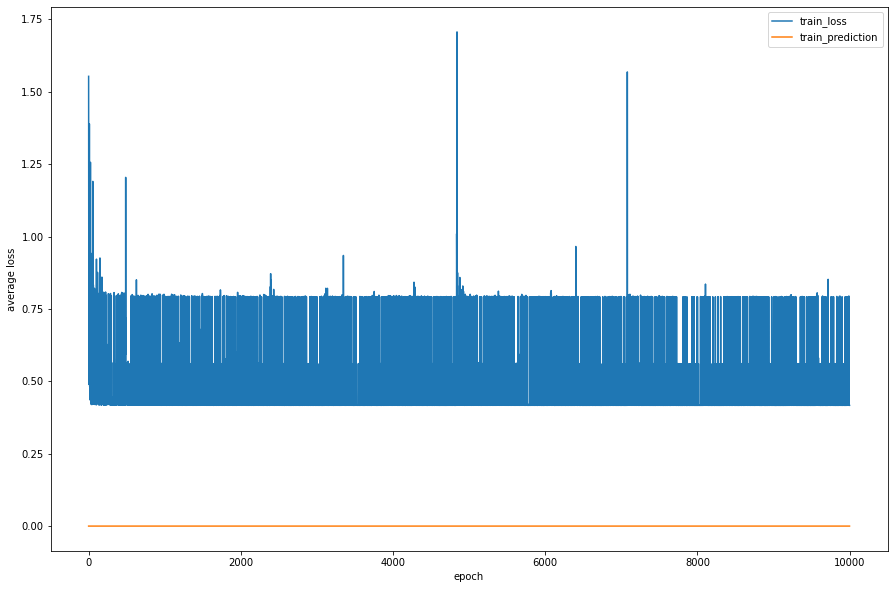

训练完毕，总用时为0小时29分18秒


([1.5533053874969482,
  1.1082485914230347,
  0.934554934501648,
  0.9339610934257507,
  1.0213947296142578,
  0.79002445936203,
  0.4888025224208832,
  0.5297585725784302,
  0.5309041142463684,
  0.595127522945404,
  1.3891198635101318,
  0.6406630277633667,
  0.729936957359314,
  0.5585514307022095,
  0.48159462213516235,
  0.48479601740837097,
  0.5842027068138123,
  0.8589582443237305,
  0.852287232875824,
  0.6124719381332397,
  0.45004162192344666,
  0.45324772596359253,
  0.43494170904159546,
  0.48665279150009155,
  1.2563908100128174,
  0.43667685985565186,
  0.5820456743240356,
  0.645175576210022,
  0.45500195026397705,
  0.8555173277854919,
  0.9420985579490662,
  0.453339159488678,
  0.6525917649269104,
  0.4380050301551819,
  0.42167457938194275,
  0.5444766879081726,
  0.4203960597515106,
  0.6366857290267944,
  0.47110363841056824,
  0.6953641176223755,
  0.4381473660469055,
  0.4484037756919861,
  0.41946253180503845,
  0.46597421169281006,
  0.48301994800567627,
  0.4

In [16]:
def model_test(epoch=1,random_seed = 1,use_cuda =True,draw_plot=False,torch_use_deterministic_algorithms=False,learing_rate=0.0001):
    
    start_time = time.time()
    #创建随机种子
    if random_seed is not None:
        set_seed(random_seed,torch_use_deterministic_algorithms)
        if torch_use_deterministic_algorithms:
            print('随机种子设定成功，模式已经修改为固定初始数；torch使用deterministic算法')
        else:
            print('随机种子设定成功，模式已经修改为固定初始数；torch使用non-deterministic算法')
    else:
        random_seed = None

    #获取train和valid数据来源，只取前10个数据作为训练的内容，不进行验证
    train_img_path = glob.glob('mchar_train/*.png')
    train_img_path = train_img_path[:10]
    train_json = json.load(open('mchar_train.json'))
    train_label = [train_json[x]['label'] for x in train_json]
    train_label = train_label[:10]

    #确定图像处理步骤
    my_img_transforms = transforms.Compose([transforms.Resize((64,128)),
                                           transforms.ColorJitter(0.3,0.3,0.3),
                                           transforms.RandomRotation(5),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])  #transforms.Compose()接收的是一个list参数，不能是单个的transforms功能直接传入，另外transforms.resize()需要传入tupleer

    #实例化Dataset
    my_train_dataset = MyDataset(train_img_path,train_label,transforms=my_img_transforms,use_cuda=use_cuda)

    #实例化网络模型
    cnn_model1 = MyModel() 

    #实例化DataLoader
    my_train_dataloader = DataLoader(my_train_dataset,batch_size=1,shuffle=True)
    
    #实例化损失函数
    my_criterion = nn.CrossEntropyLoss()
    
    #实例化优化器
    my_optimizet = torch.optim.Adam(cnn_model1.parameters(),lr=learing_rate) 

    #进行训练，将每个epoch的训练结果和验证结果存入列表
    train_loss_list=[]
    train_prediction_list=[]
    train_epoch_time_list = []
    
    for epoch_index in range(1,epoch+1):
        print(f'第{epoch_index}个epoch:')
        
        train_loss,train_prediction,epoch_time = my_train(cnn_model1,my_train_dataloader,my_criterion,my_optimizet,use_cuda=use_cuda)
        
        train_loss_list.append(train_loss)
        train_prediction_list.append(train_prediction)
        train_epoch_time_list.append(epoch_time)
        
    #绘制训练曲线
    if draw_plot:
        fig1 = plt.figure(figsize=(15,10))
        plt.plot([x for x in range(epoch)],train_loss_list,label='train_loss')
        plt.plot([x for x in range(epoch)],train_prediction_list,label='train_prediction')
        plt.xlabel('epoch')
        plt.ylabel('average loss')
        plt.legend()
        plt.show()
        
    end_time = time.time()
    all_epoch_time = end_time-start_time
    print(f'训练完毕，总用时为{int((all_epoch_time//60)//60)}小时{int(all_epoch_time//60)}分{int(all_epoch_time%60)}秒')
    
    return train_loss_list,train_prediction_list,train_epoch_time_list

model_test(epoch=10000,random_seed = 1,use_cuda =True,draw_plot=True,torch_use_deterministic_algorithms=False,learing_rate=0.0016)